In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
sharansmenon_div2k_path = kagglehub.dataset_download('sharansmenon/div2k')

print('Data source import complete.')


 13%|█▎        | 503M/3.71G [00:05<00:38, 88.8MB/s]


KeyboardInterrupt: 

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
import torch
import math
from os import listdir
import numpy as np
from torch.autograd import Variable

In [ ]:
from PIL import Image
from os.path import join

In [ ]:
from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize

In [ ]:
from torch.utils.data import DataLoader, Dataset

In [ ]:
torch.autograd.set_detect_anomaly(True)

In [ ]:
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG'])


def calculate_valid_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)


def train_hr_transform(crop_size):
    return Compose([
        RandomCrop(crop_size),
        ToTensor(),
    ])


def train_lr_transform(crop_size, upscale_factor):
    return Compose([
        ToPILImage(),
        Resize(crop_size // upscale_factor, interpolation=Image.BICUBIC),
        ToTensor()
    ])


def display_transform():
    return Compose([
        ToPILImage(),
        Resize(400),
        CenterCrop(400),
        ToTensor()
    ])

In [ ]:
class TrainDatasetFromFolder(Dataset):
    def __init__(self, dataset_dir, crop_size, upscale_factor):
        super(TrainDatasetFromFolder, self).__init__()
        self.image_filenames = [join(dataset_dir, x) for x in listdir(dataset_dir) if is_image_file(x)]
        crop_size = calculate_valid_crop_size(crop_size, upscale_factor)
        self.hr_transform = train_hr_transform(crop_size)
        self.lr_transform = train_lr_transform(crop_size, upscale_factor)

    def __getitem__(self, index):
        hr_image = self.hr_transform(Image.open(self.image_filenames[index]))
        lr_image = self.lr_transform(hr_image)
        return lr_image, hr_image

    def __len__(self):
        return len(self.image_filenames)

In [ ]:
UPSCALE_FACTOR = 4
CROP_SIZE = 88

In [ ]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [ ]:
from google.colab import drive
drive.mount('/content/drive_new')


Drive already mounted at /content/drive_new; to attempt to forcibly remount, call drive.mount("/content/drive_new", force_remount=True).


In [ ]:
import os
from torch.utils.data import DataLoader



In [ ]:
TRAIN_HR_DIR = '/content/drive_new/MyDrive/DIV2K_train_HR'
print("Number of training images:", len(os.listdir(TRAIN_HR_DIR)))
train_set = TrainDatasetFromFolder(
    TRAIN_HR_DIR,
    crop_size=CROP_SIZE,
    upscale_factor=UPSCALE_FACTOR
)

Number of training images: 800


In [ ]:
train_loader = DataLoader(
    dataset=train_set,
    batch_size=64,
    shuffle=True,
    num_workers=0, # Changed from 4 to 0 to resolve FileNotFoundError in worker processes
    pin_memory=True
)


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

## Model

We are going to define the model here.

In [ ]:
from torch import nn, optim

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.prelu(residual)
        residual = self.conv2(residual)
        residual = self.bn2(residual)

        return x + residual

In [ ]:
class UpsampleBLock(nn.Module):
    def __init__(self, in_channels, up_scale):
        super(UpsampleBLock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * up_scale ** 2, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(up_scale)
        self.prelu = nn.PReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.prelu(x)
        return x

In [ ]:
class Generator(nn.Module):
    def __init__(self, scale_factor):
        upsample_block_num = int(math.log(scale_factor, 2))

        super(Generator, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),
            nn.PReLU()
        )
        self.block2 = ResidualBlock(64)
        self.block3 = ResidualBlock(64)
        self.block4 = ResidualBlock(64)
        self.block5 = ResidualBlock(64)
        self.block6 = ResidualBlock(64)
        self.block7 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
        )
        block8 = [UpsampleBLock(64, 2) for _ in range(upsample_block_num)]
        block8.append(nn.Conv2d(64, 3, kernel_size=9, padding=4))
        self.block8 = nn.Sequential(*block8)

    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)
        block6 = self.block6(block5)
        block7 = self.block7(block6)
        block8 = self.block8(block1 + block7)

        return (torch.tanh(block8) + 1) / 2

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(512, 1024, kernel_size=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(1024, 1, kernel_size=1)
        )

    def forward(self, x):
        batch_size = x.size(0)
        return torch.sigmoid(self.net(x).view(batch_size))

In [ ]:
from torchvision.models.vgg import vgg16

In [ ]:
class GeneratorLoss(nn.Module):
    def __init__(self):
        super(GeneratorLoss, self).__init__()
        vgg = vgg16(pretrained=True)
        loss_network = nn.Sequential(*list(vgg.features)[:31]).eval()
        for param in loss_network.parameters():
            param.requires_grad = False
        self.loss_network = loss_network
        self.mse_loss = nn.MSELoss()
        self.tv_loss = TVLoss()

    def forward(self, out_labels, out_images, target_images):
        # Adversarial Loss
        adversarial_loss = torch.mean(1 - out_labels)
        # Perception Loss
        perception_loss = self.mse_loss(self.loss_network(out_images), self.loss_network(target_images))
        # Image Loss
        image_loss = self.mse_loss(out_images, target_images)
        # TV Loss
        tv_loss = self.tv_loss(out_images)
        return image_loss + 0.001 * adversarial_loss + 0.006 * perception_loss + 2e-8 * tv_loss


In [ ]:
class TVLoss(nn.Module):
    def __init__(self, tv_loss_weight=1):
        super(TVLoss, self).__init__()
        self.tv_loss_weight = tv_loss_weight

    def forward(self, x):
        batch_size = x.size()[0]
        h_x = x.size()[2]
        w_x = x.size()[3]
        count_h = self.tensor_size(x[:, :, 1:, :])
        count_w = self.tensor_size(x[:, :, :, 1:])
        h_tv = torch.pow((x[:, :, 1:, :] - x[:, :, :h_x - 1, :]), 2).sum()
        w_tv = torch.pow((x[:, :, :, 1:] - x[:, :, :, :w_x - 1]), 2).sum()
        return self.tv_loss_weight * 2 * (h_tv / count_h + w_tv / count_w) / batch_size

    @staticmethod
    def tensor_size(t):
        return t.size()[1] * t.size()[2] * t.size()[3]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [ ]:
netG = Generator(UPSCALE_FACTOR)
netD = Discriminator()
generator_criterion = GeneratorLoss()

In [ ]:
generator_criterion = generator_criterion.to(device)
netG = netG.to(device)
netD = netD.to(device)

In [ ]:
optimizerG = optim.Adam(netG.parameters(), lr=0.0002)
optimizerD = optim.Adam(netD.parameters(), lr=0.0002)

In [ ]:
results = {'d_loss': [], 'g_loss': [], 'd_score': [], 'g_score': [], 'psnr': [], 'ssim': []}

In [ ]:
from tqdm import tqdm
import os

In [ ]:
N_EPOCHS = 60

In [ ]:
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import os
import torch
from torch.autograd import Variable
from tqdm import tqdm

SAVE_ROOT = '/content/drive/MyDrive/SRGAN_results'  # CHANGE if needed
os.makedirs(SAVE_ROOT, exist_ok=True)

# Lists to store metrics for plotting
all_d_losses = []
all_g_losses = []
all_d_scores = []
all_g_scores = []

for epoch in range(1, N_EPOCHS + 1):
    train_bar = tqdm(train_loader)
    running_results = {
        'batch_sizes': 0,
        'd_loss': 0,
        'g_loss': 0,
        'd_score': 0,
        'g_score': 0
    }

    netG.train()
    netD.train()

    for data, target in train_bar:
        batch_size = data.size(0)
        running_results['batch_sizes'] += batch_size

        real_img = target.cuda() if torch.cuda.is_available() else target
        z = data.cuda() if torch.cuda.is_available() else data

        ############################
        # (1) Update Discriminator
        ############################
        fake_img = netG(z)

        netD.zero_grad()
        real_out = netD(real_img).mean()
        fake_out = netD(fake_img.detach()).mean()

        d_loss = 1 - real_out + fake_out
        d_loss.backward()
        optimizerD.step()

        ############################
        # (2) Update Generator
        ############################
        netG.zero_grad()

        fake_img = netG(z)
        fake_out = netD(fake_img).mean()

        g_loss = generator_criterion(fake_out, fake_img, real_img)
        g_loss.backward()
        optimizerG.step()

        ############################
        # Logging
        ############################
        running_results['g_loss'] += g_loss.item() * batch_size
        running_results['d_loss'] += d_loss.item() * batch_size
        running_results['d_score'] += real_out.item() * batch_size
        running_results['g_score'] += fake_out.item() * batch_size

        train_bar.set_description(
            '[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f' %
            (
                epoch, N_EPOCHS,
                running_results['d_loss'] / running_results['batch_sizes'],
                running_results['g_loss'] / running_results['batch_sizes'],
                running_results['d_score'] / running_results['batch_sizes'],
                running_results['g_score'] / running_results['batch_sizes']
            )
        )

    ############################
    # Save metrics for this epoch
    ############################
    all_d_losses.append(running_results['d_loss'] / running_results['batch_sizes'])
    all_g_losses.append(running_results['g_loss'] / running_results['batch_sizes'])
    all_d_scores.append(running_results['d_score'] / running_results['batch_sizes'])
    all_g_scores.append(running_results['g_score'] / running_results['batch_sizes'])

    ############################
    # ---- END OF EPOCH ----
    ############################
    netG.eval()

    with torch.no_grad():
        lr_img = z[0].cpu()
        sr_img = fake_img[0].cpu()
        hr_img = real_img[0].cpu()

        # ---- DISPLAY EVERY EPOCH ----
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(lr_img.permute(1, 2, 0))
        axs[0].set_title(f"LR - Epoch {epoch}")
        axs[0].axis("off")

        axs[1].imshow(sr_img.permute(1, 2, 0))
        axs[1].set_title("SR")
        axs[1].axis("off")

        axs[2].imshow(hr_img.permute(1, 2, 0))
        axs[2].set_title("HR")
        axs[2].axis("off")

        plt.show()

        # ---- SAVE IMAGES EVERY 5 EPOCHS ----
        if epoch % 5 == 0:
            img_dir = f'{SAVE_ROOT}/images/epoch_{epoch}'
            os.makedirs(img_dir, exist_ok=True)

            save_image(lr_img, f'{img_dir}/LR.png', normalize=True)
            save_image(sr_img, f'{img_dir}/SR.png', normalize=True)
            save_image(hr_img, f'{img_dir}/HR.png', normalize=True)

    ############################
    # ---- SAVE MODELS EVERY 10 EPOCHS ----
    ############################
    if epoch % 10 == 0:
        torch.save(netG.state_dict(), f'{SAVE_ROOT}/netG_epoch_{epoch}.pth')
        torch.save(netD.state_dict(), f'{SAVE_ROOT}/netD_epoch_{epoch}.pth')

# ---- SAVE FINAL MODELS ALWAYS ----
torch.save(netG.state_dict(), f'{SAVE_ROOT}/netG_final.pth')
torch.save(netD.state_dict(), f'{SAVE_ROOT}/netD_final.pth')

############################
# ---- PLOT TRAINING METRICS ----
############################
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, N_EPOCHS + 1), all_d_losses, label='D Loss')
plt.plot(range(1, N_EPOCHS + 1), all_g_losses, label='G Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator & Discriminator Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, N_EPOCHS + 1), all_d_scores, label='D(x)')
plt.plot(range(1, N_EPOCHS + 1), all_g_scores, label='D(G(z))')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Discriminator Outputs')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
torch.save(netG.state_dict(), "super_res_gen.pth")

SUPER RESOLUTION BY THE CNN METHOD

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
import matplotlib.pyplot as plt
import os



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
UPSCALE_FACTOR = 4
CROP_SIZE = 88

In [ ]:
CNN_EPOCHS=60

In [ ]:
import torch
print(torch.cuda.is_available())  # should print True


True


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [ ]:
import torch
import torch.nn as nn

class UpsampleBLock(nn.Module):
    def __init__(self, in_channels, up_scale):
        super(UpsampleBLock, self).__init__()
        # Learned upsampling via PixelShuffle
        self.conv = nn.Conv2d(in_channels, in_channels * (up_scale ** 2), kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(up_scale)
        self.prelu = nn.PReLU()

    def forward(self, x):
        x=self.conv(x)
        x=self.prelu(x)
        return self.pixel_shuffle(x)

        return self.prelu(self.pixel_shuffle(self.conv(x)))

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels),
            nn.PReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels)
        )

    def forward(self, x):
        return x + self.block(x) # Skip connection for gradient flow

class SuperResolutionCNN(nn.Module):
    def __init__(self):
        super(SuperResolutionCNN, self).__init__()

        # Layer 1: Initial Feature Extraction
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1) # 3x3 better for small 22x22
        self.prelu = nn.PReLU()

        # Layers 2-13: Deep Residual Mapping (6 blocks * 2 layers each)
        res_layers = [ResidualBlock(64) for _ in range(6)]
        self.res_blocks = nn.Sequential(*res_layers)

        # Layer 14: Upsampling Stage (22x22 -> 44x44 -> 88x88)
        self.upsample = nn.Sequential(
            UpsampleBLock(64, 2),
            UpsampleBLock(64, 2)
        )

        # Layer 15: Final Reconstruction
        self.conv_final = nn.Conv2d(64, 3, kernel_size=3, padding=1)

    def forward(self, x):
        f1 = self.prelu(self.conv1(x))
        res = self.res_blocks(f1)
        up = self.upsample(f1 + res) # Global residual learning
        return self.conv_final(up)

In [ ]:

# Initialization
model = SuperResolutionCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Loss Definitions
criterion_mse = nn.MSELoss()
criterion_l1 = nn.L1Loss()
lambda_l1 = 0.1 # Strength of L1 loss

for epoch in range(1, CNN_EPOCHS + 1):
    model.train()
    for lr_img, hr_img in train_loader:
        lr_img, hr_img = lr_img.to(device), hr_img.to(device) # lr: 22x22, hr: 88x88

        optimizer.zero_grad()
        sr_img = model(lr_img) # Output: 88x88

        # --- Combined Loss Calculation ---
        mse_loss = criterion_mse(sr_img, hr_img)
        l1_loss = criterion_l1(sr_img, hr_img)

        total_loss = mse_loss + (lambda_l1 * l1_loss)
        # ---------------------------------

        total_loss.backward()
        optimizer.step()

Drive already mounted at /content/drive_new; to attempt to forcibly remount, call drive.mount("/content/drive_new", force_remount=True).


Epoch [1/60]: 100%|██████████| 13/13 [01:20<00:00,  6.18s/it, loss=0.062711]


 >> Epoch [1/60] Finished. Average Loss: 0.15408907


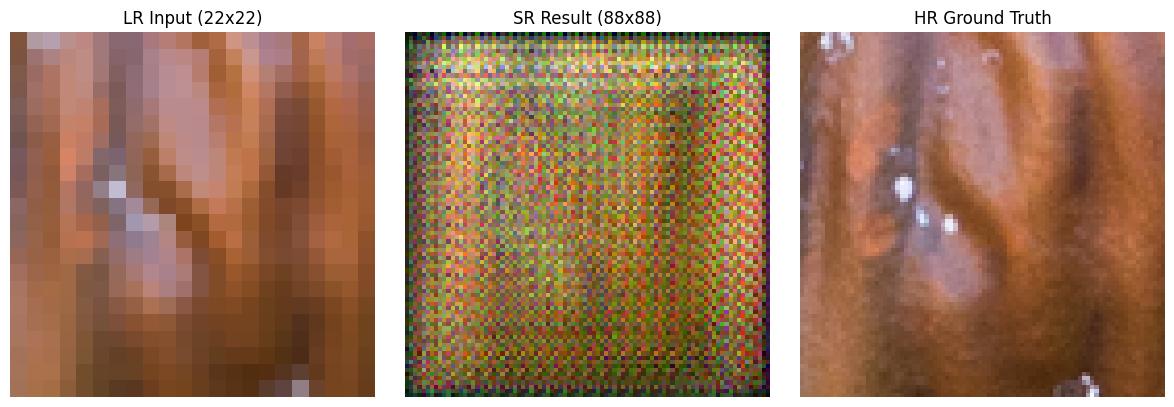

Epoch [2/60]: 100%|██████████| 13/13 [01:19<00:00,  6.15s/it, loss=0.033703]


 >> Epoch [2/60] Finished. Average Loss: 0.04491229


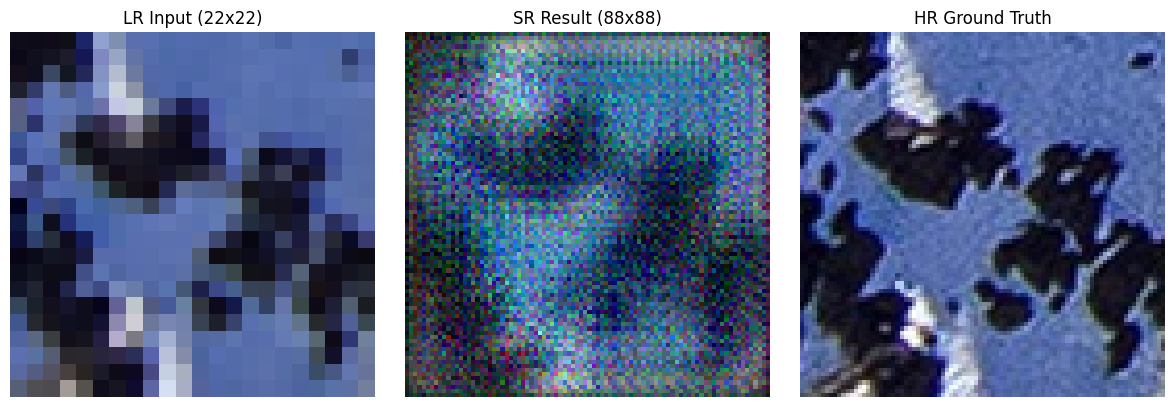

Epoch [3/60]: 100%|██████████| 13/13 [01:19<00:00,  6.13s/it, loss=0.025090]

 >> Epoch [3/60] Finished. Average Loss: 0.02990803


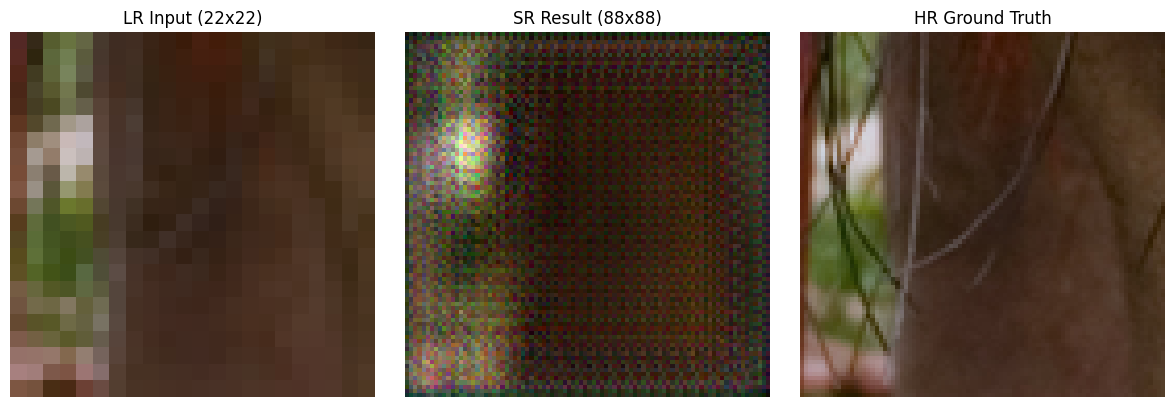

Epoch [4/60]: 100%|██████████| 13/13 [01:19<00:00,  6.13s/it, loss=0.025257]


 >> Epoch [4/60] Finished. Average Loss: 0.02566172


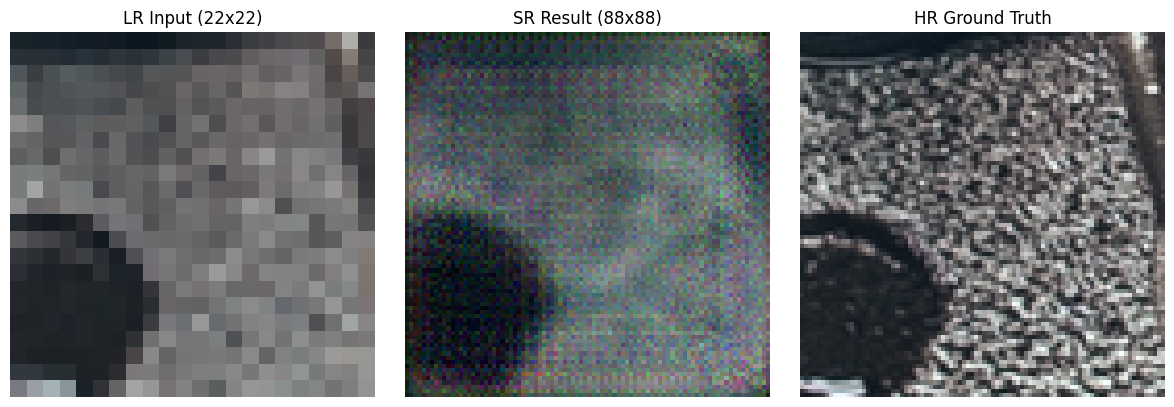

Epoch [5/60]: 100%|██████████| 13/13 [01:19<00:00,  6.15s/it, loss=0.019527]

 >> Epoch [5/60] Finished. Average Loss: 0.02167014


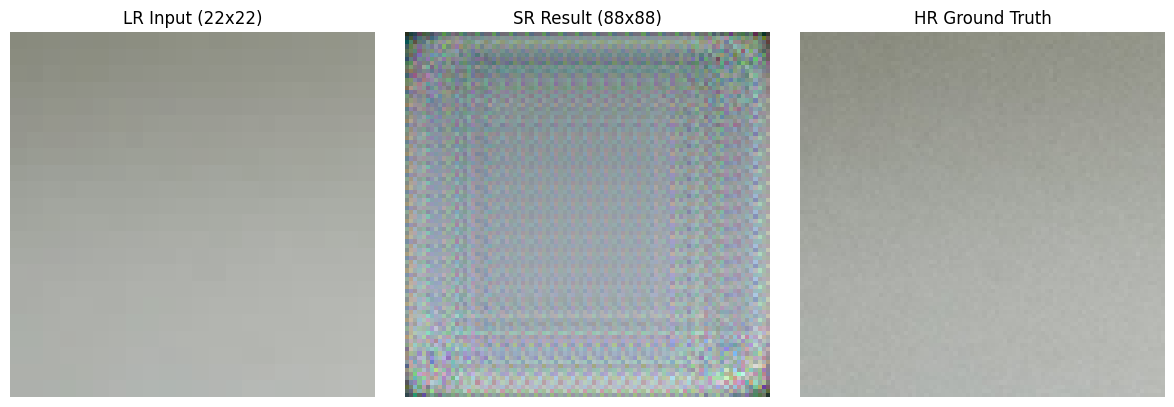


[!] Images saved to /content/drive_new/MyDrive/SR_CNN_Results/images_epoch_5


Epoch [6/60]: 100%|██████████| 13/13 [01:19<00:00,  6.11s/it, loss=0.018483]

 >> Epoch [6/60] Finished. Average Loss: 0.01961310


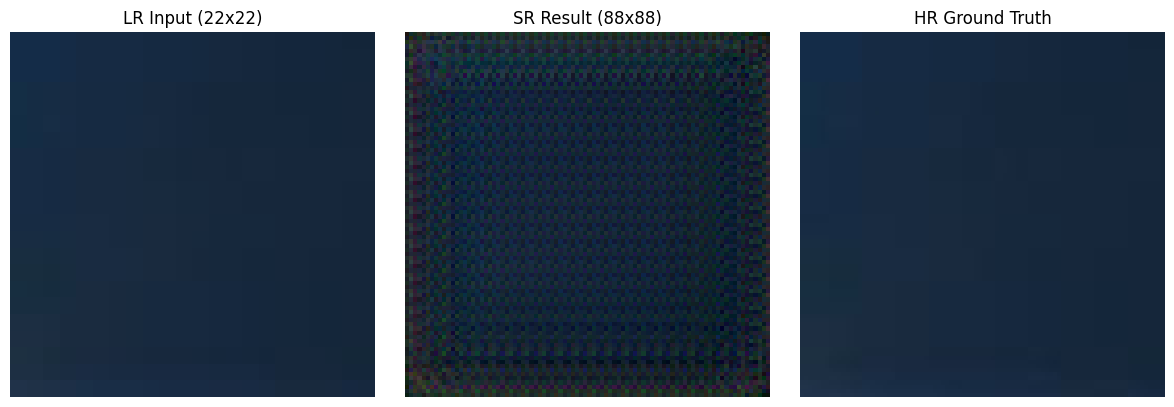

Epoch [7/60]: 100%|██████████| 13/13 [01:19<00:00,  6.13s/it, loss=0.019384]

 >> Epoch [7/60] Finished. Average Loss: 0.01977296


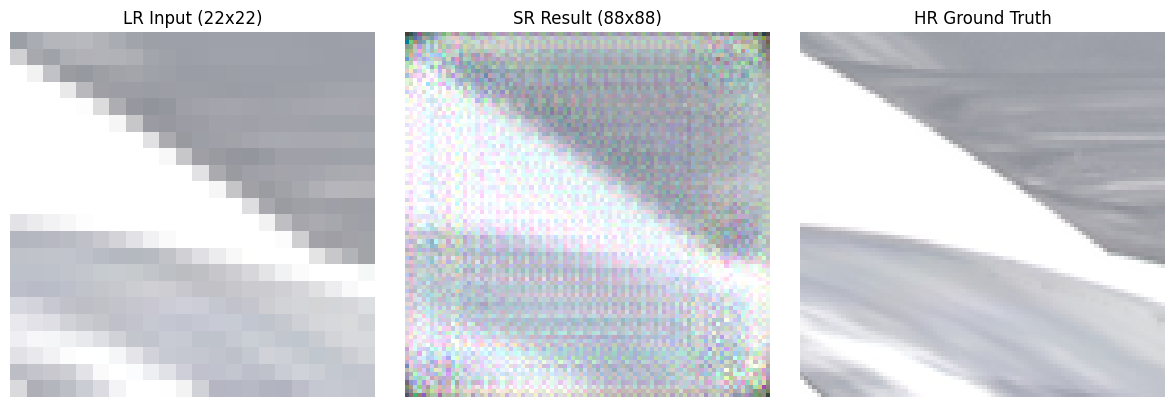

Epoch [8/60]: 100%|██████████| 13/13 [01:19<00:00,  6.12s/it, loss=0.017882]

 >> Epoch [8/60] Finished. Average Loss: 0.01756720


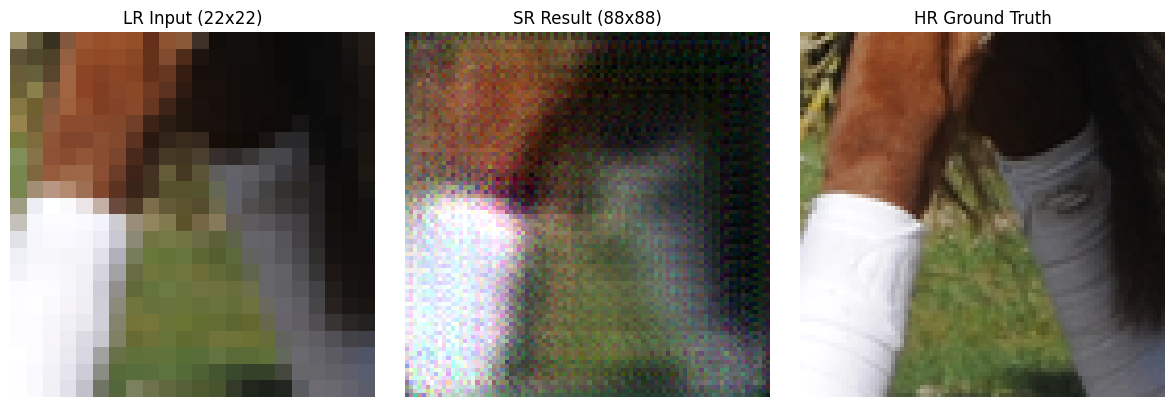

Epoch [9/60]: 100%|██████████| 13/13 [01:19<00:00,  6.13s/it, loss=0.014163]

 >> Epoch [9/60] Finished. Average Loss: 0.01723841


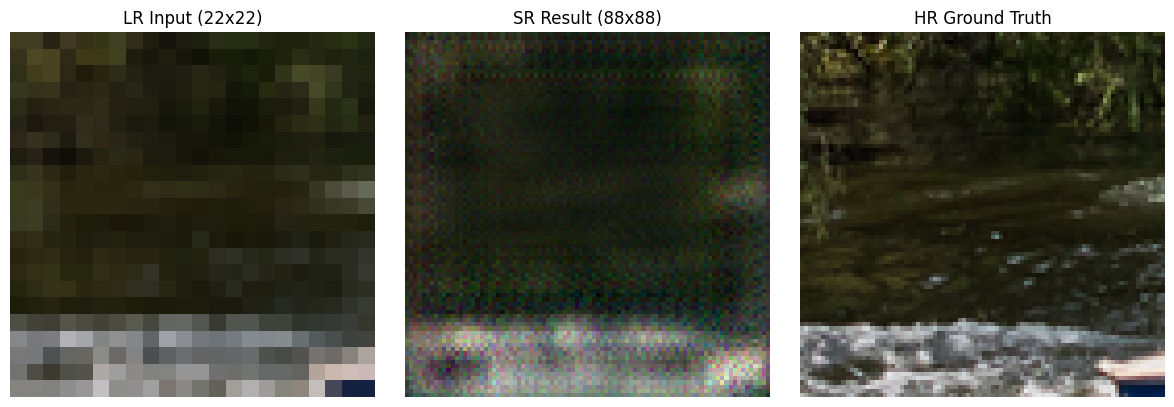

Epoch [10/60]: 100%|██████████| 13/13 [01:20<00:00,  6.19s/it, loss=0.016035]

 >> Epoch [10/60] Finished. Average Loss: 0.01540206


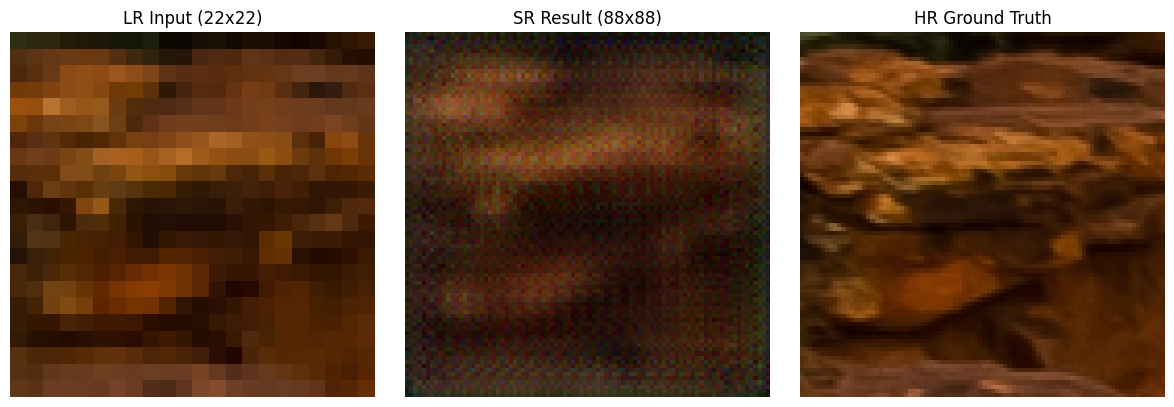


[!] Images saved to /content/drive_new/MyDrive/SR_CNN_Results/images_epoch_10
[!] Checkpoint saved: /content/drive_new/MyDrive/SR_CNN_Results/checkpoint_epoch_10.pth


Epoch [11/60]: 100%|██████████| 13/13 [01:19<00:00,  6.14s/it, loss=0.015430]

 >> Epoch [11/60] Finished. Average Loss: 0.01432091


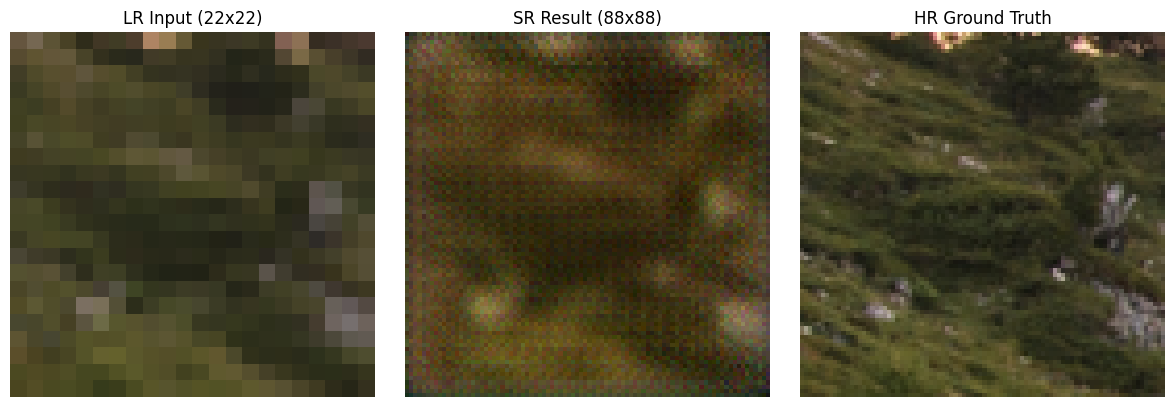

Epoch [12/60]: 100%|██████████| 13/13 [01:19<00:00,  6.14s/it, loss=0.015055]

 >> Epoch [12/60] Finished. Average Loss: 0.01424846


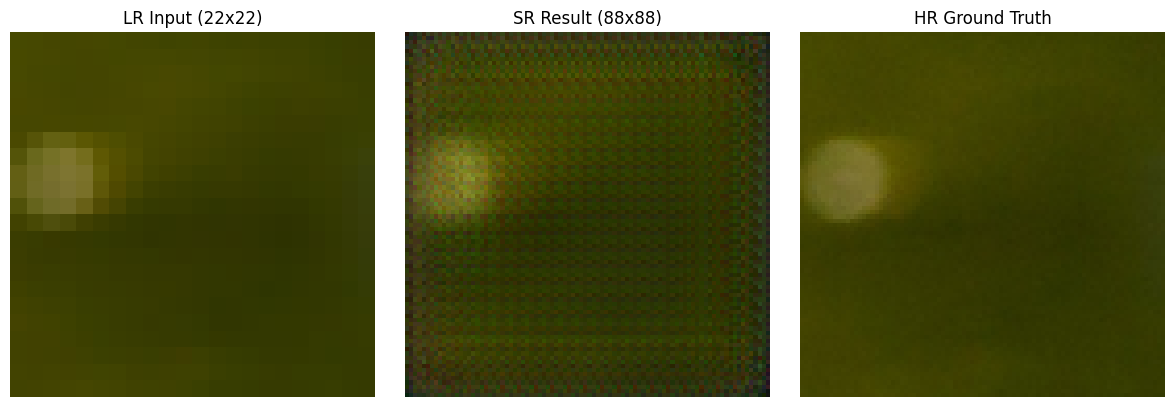

Epoch [13/60]: 100%|██████████| 13/13 [01:19<00:00,  6.14s/it, loss=0.017203]

 >> Epoch [13/60] Finished. Average Loss: 0.01505485


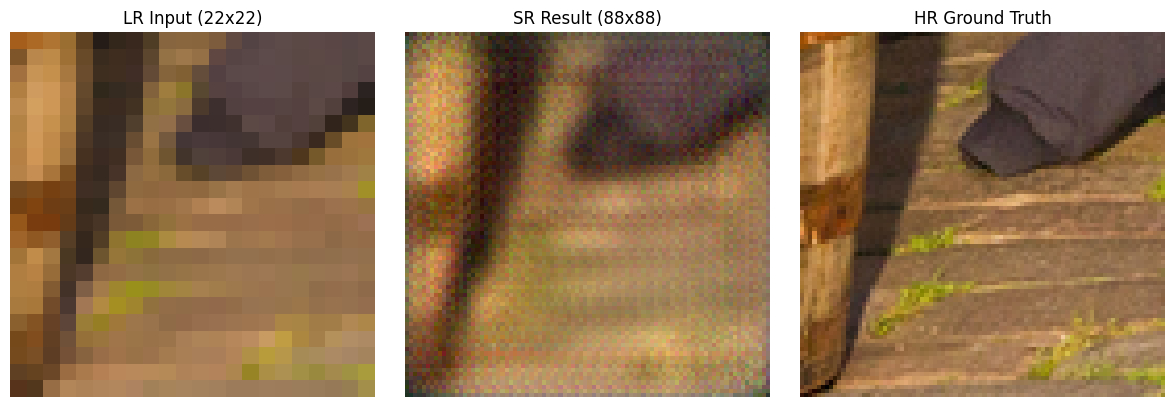

Epoch [14/60]: 100%|██████████| 13/13 [01:19<00:00,  6.14s/it, loss=0.016739]


 >> Epoch [14/60] Finished. Average Loss: 0.01417625


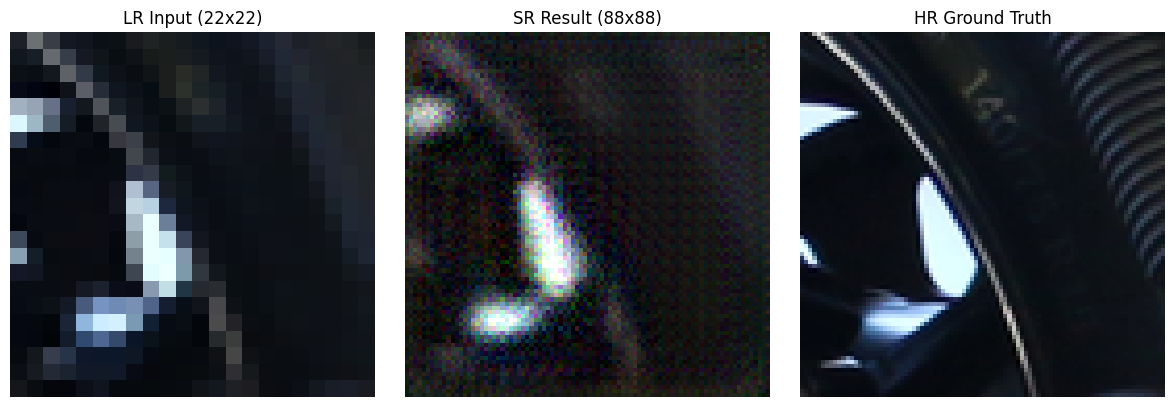

Epoch [15/60]: 100%|██████████| 13/13 [01:19<00:00,  6.13s/it, loss=0.011657]

 >> Epoch [15/60] Finished. Average Loss: 0.01372694


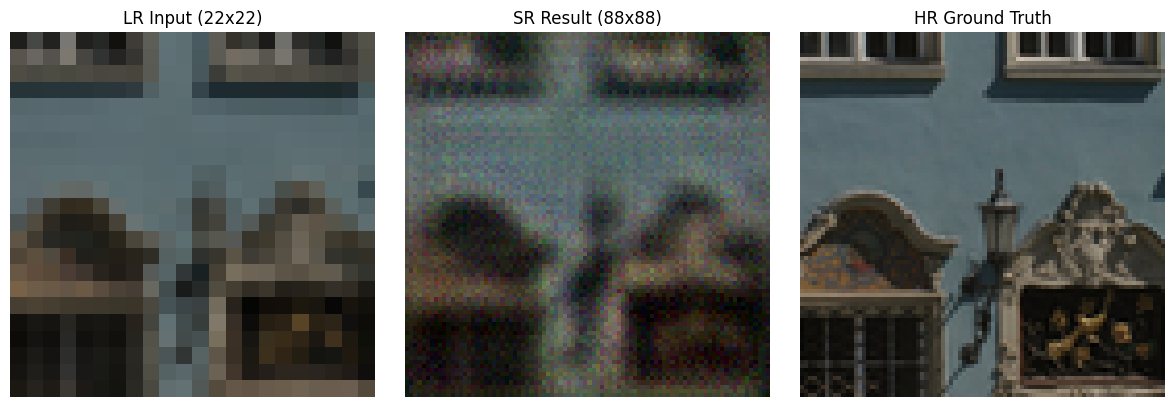


[!] Images saved to /content/drive_new/MyDrive/SR_CNN_Results/images_epoch_15


Epoch [16/60]: 100%|██████████| 13/13 [01:20<00:00,  6.15s/it, loss=0.011483]

 >> Epoch [16/60] Finished. Average Loss: 0.01295413


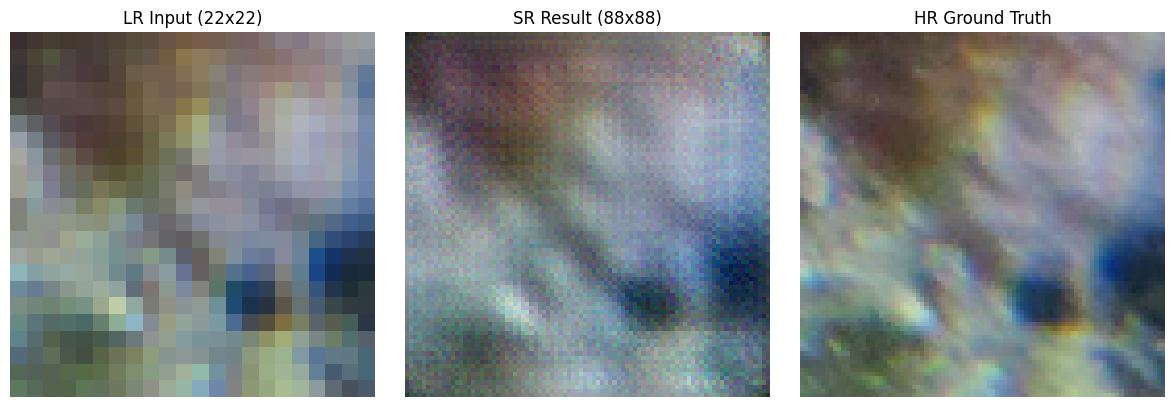

Epoch [17/60]: 100%|██████████| 13/13 [01:19<00:00,  6.14s/it, loss=0.017649]


 >> Epoch [17/60] Finished. Average Loss: 0.01240150


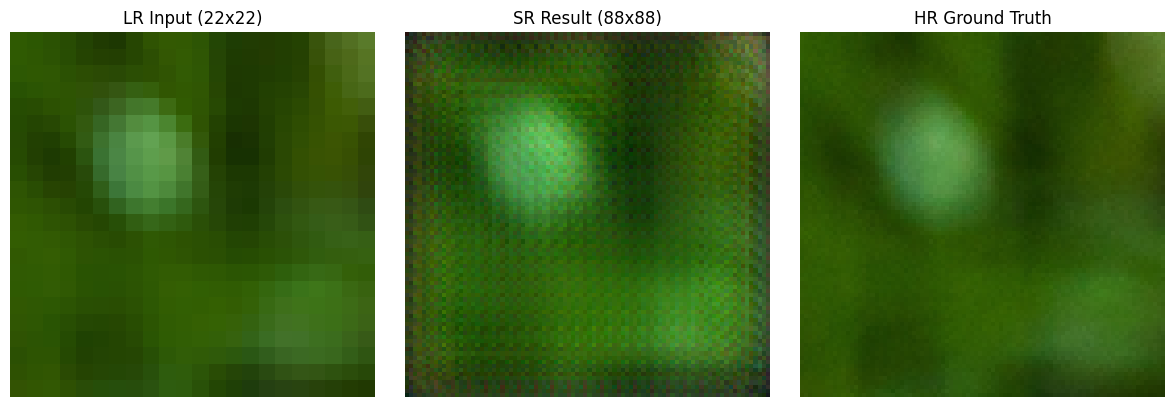

Epoch [18/60]: 100%|██████████| 13/13 [01:20<00:00,  6.19s/it, loss=0.010383]

 >> Epoch [18/60] Finished. Average Loss: 0.01252677


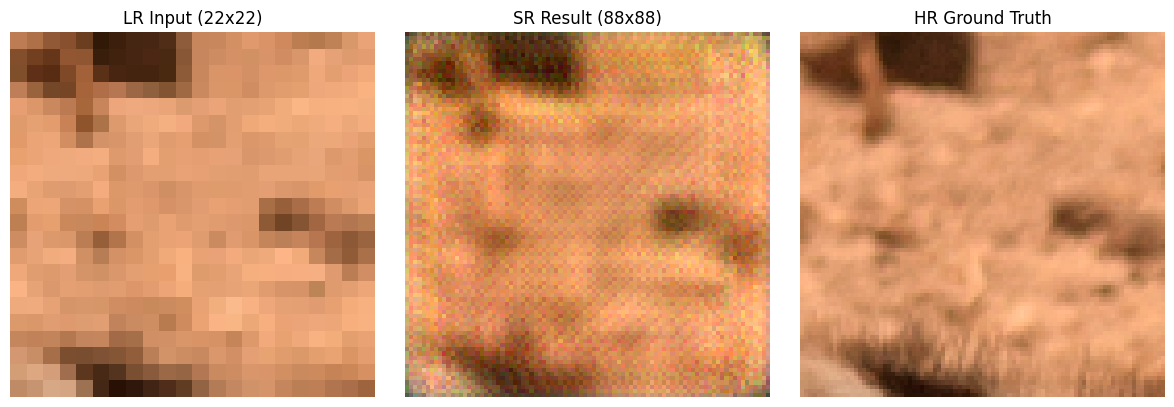

Epoch [19/60]: 100%|██████████| 13/13 [01:19<00:00,  6.13s/it, loss=0.016163]


 >> Epoch [19/60] Finished. Average Loss: 0.01332619


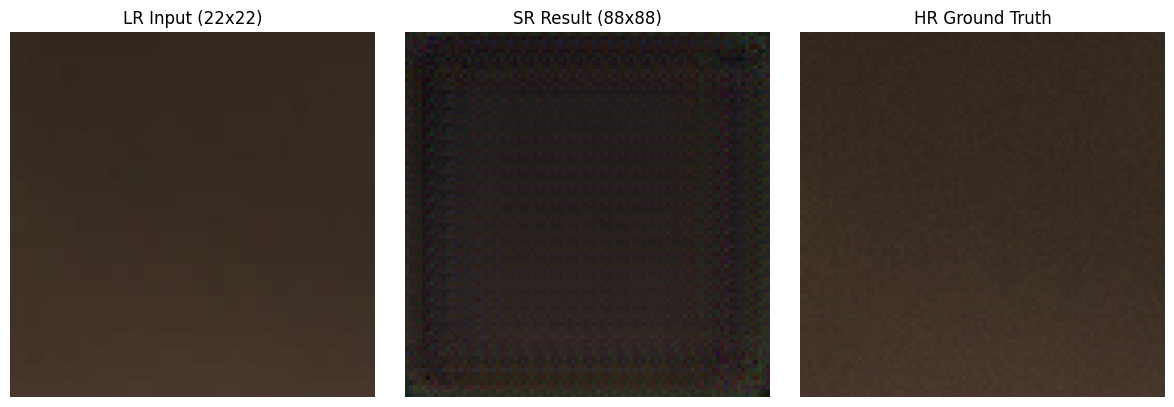

Epoch [20/60]: 100%|██████████| 13/13 [01:19<00:00,  6.14s/it, loss=0.013950]


 >> Epoch [20/60] Finished. Average Loss: 0.01317366


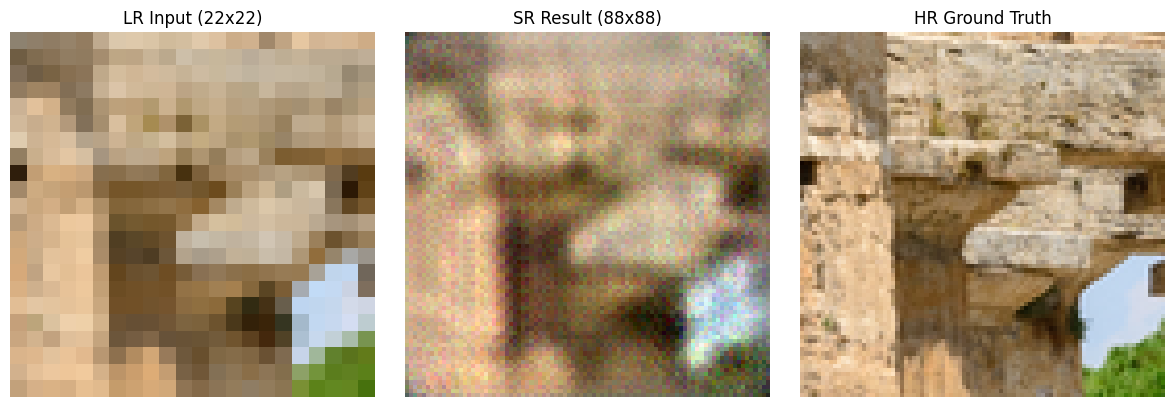


[!] Images saved to /content/drive_new/MyDrive/SR_CNN_Results/images_epoch_20
[!] Checkpoint saved: /content/drive_new/MyDrive/SR_CNN_Results/checkpoint_epoch_20.pth


Epoch [21/60]: 100%|██████████| 13/13 [01:21<00:00,  6.26s/it, loss=0.015533]


 >> Epoch [21/60] Finished. Average Loss: 0.01397887


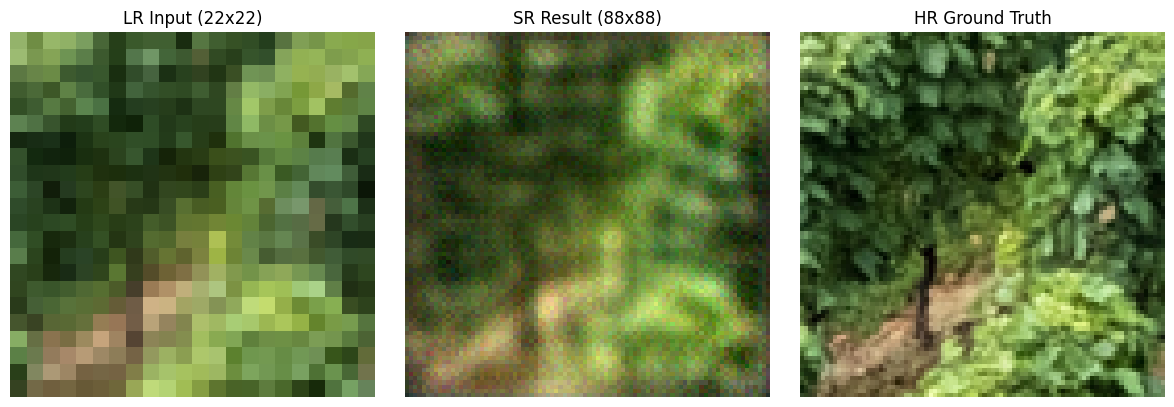

Epoch [22/60]: 100%|██████████| 13/13 [01:21<00:00,  6.24s/it, loss=0.018290]


 >> Epoch [22/60] Finished. Average Loss: 0.01420187


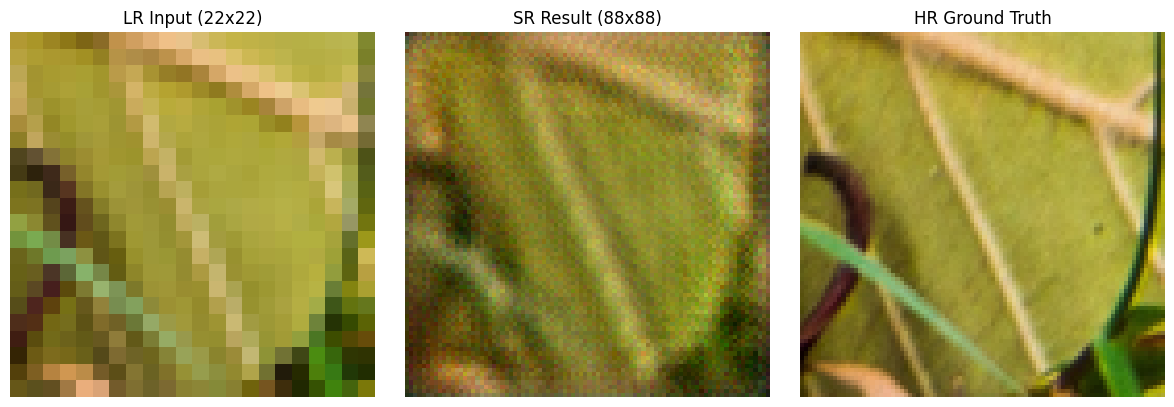

Epoch [23/60]: 100%|██████████| 13/13 [01:20<00:00,  6.19s/it, loss=0.014255]


 >> Epoch [23/60] Finished. Average Loss: 0.01441110


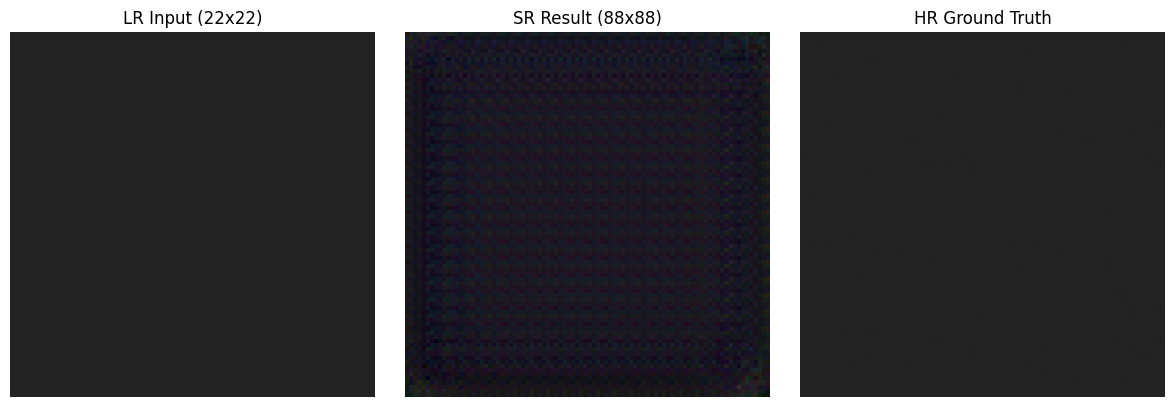

Epoch [24/60]: 100%|██████████| 13/13 [01:20<00:00,  6.16s/it, loss=0.010579]


 >> Epoch [24/60] Finished. Average Loss: 0.01113438


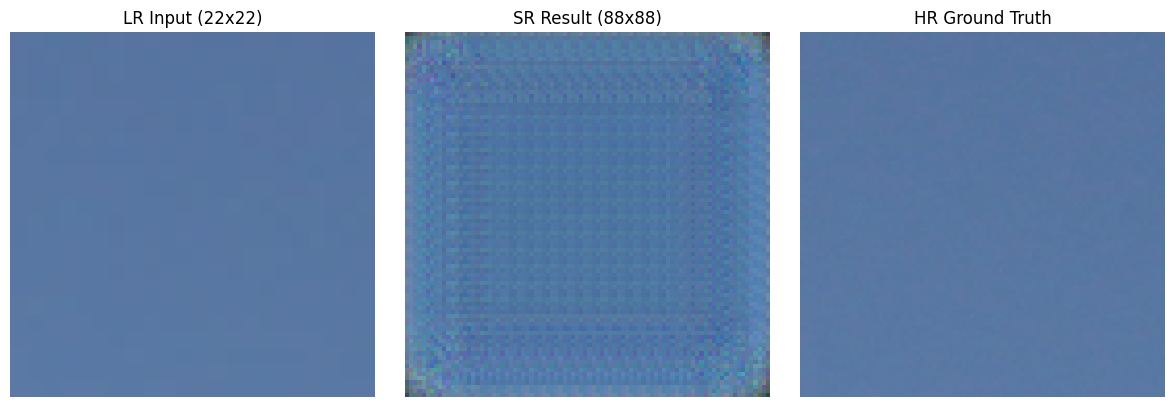

Epoch [25/60]: 100%|██████████| 13/13 [01:20<00:00,  6.16s/it, loss=0.017514]


 >> Epoch [25/60] Finished. Average Loss: 0.01208512


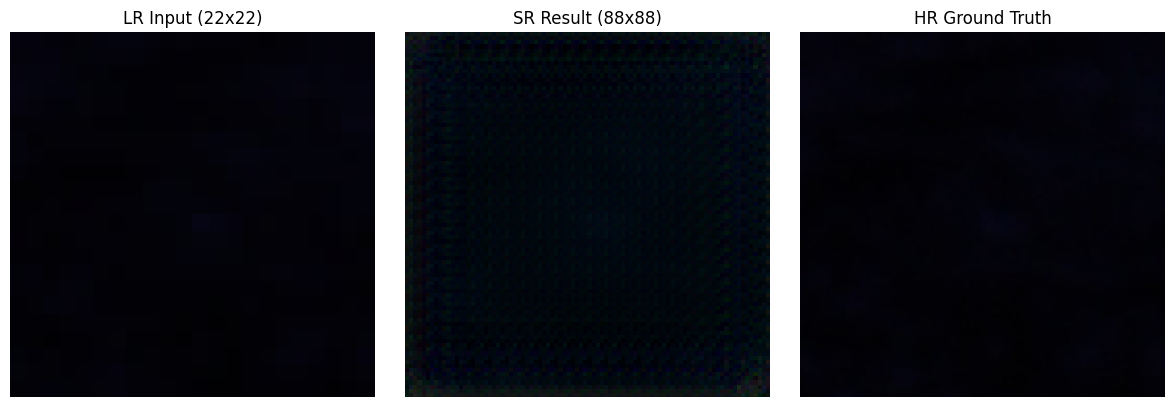


[!] Images saved to /content/drive_new/MyDrive/SR_CNN_Results/images_epoch_25


Epoch [26/60]: 100%|██████████| 13/13 [01:20<00:00,  6.18s/it, loss=0.014252]


 >> Epoch [26/60] Finished. Average Loss: 0.01139605


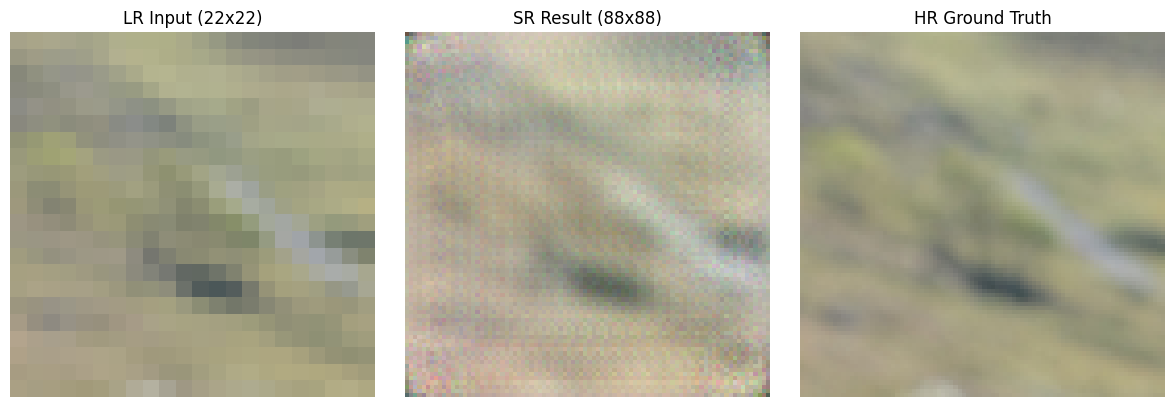

Epoch [27/60]: 100%|██████████| 13/13 [01:20<00:00,  6.16s/it, loss=0.015028]


 >> Epoch [27/60] Finished. Average Loss: 0.01169391


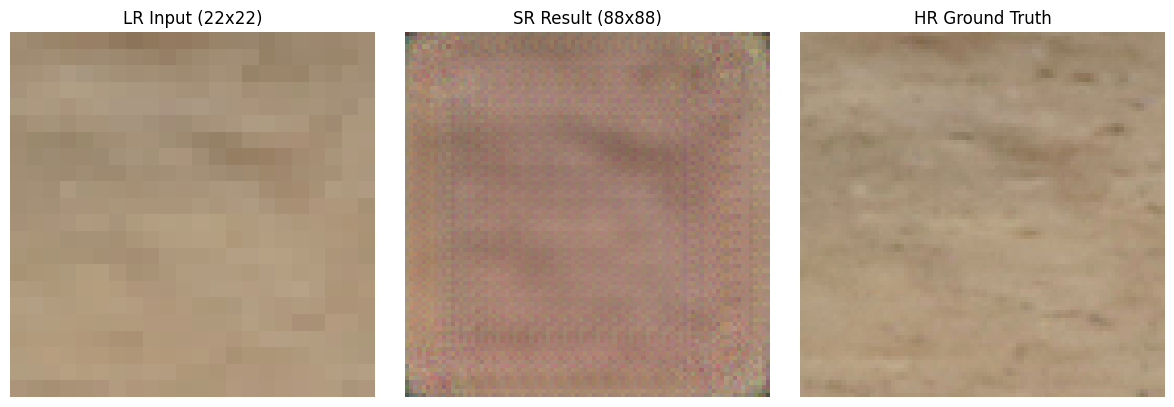

Epoch [28/60]: 100%|██████████| 13/13 [01:20<00:00,  6.19s/it, loss=0.012805]


 >> Epoch [28/60] Finished. Average Loss: 0.01060826


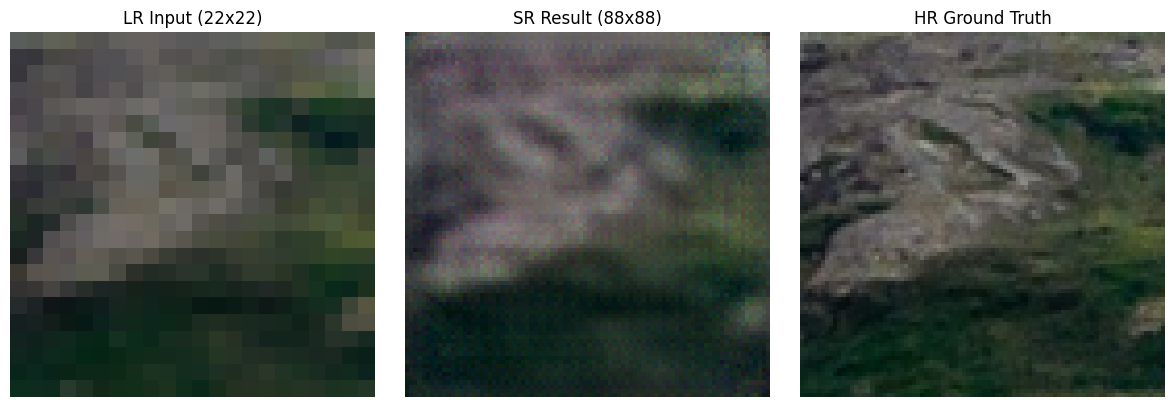

Epoch [29/60]: 100%|██████████| 13/13 [01:20<00:00,  6.21s/it, loss=0.009730]


 >> Epoch [29/60] Finished. Average Loss: 0.01104478


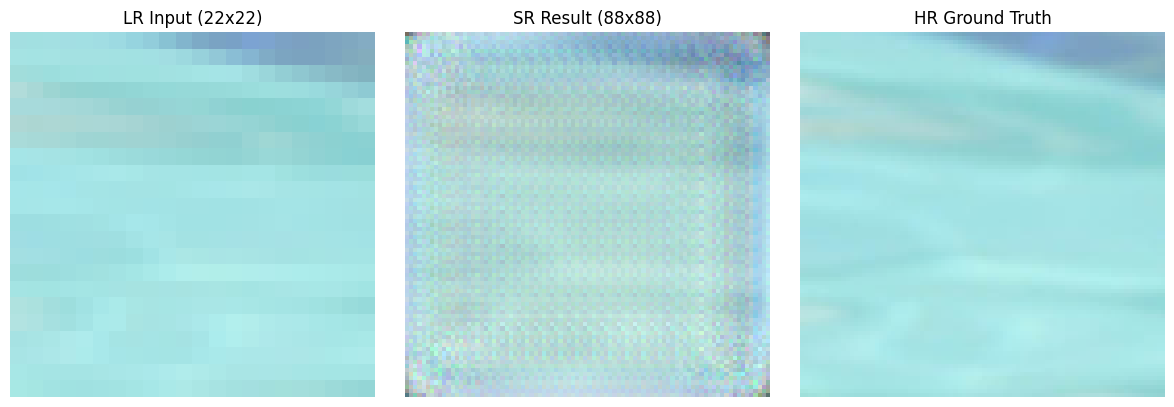

Epoch [30/60]: 100%|██████████| 13/13 [01:21<00:00,  6.23s/it, loss=0.015599]


 >> Epoch [30/60] Finished. Average Loss: 0.01129017


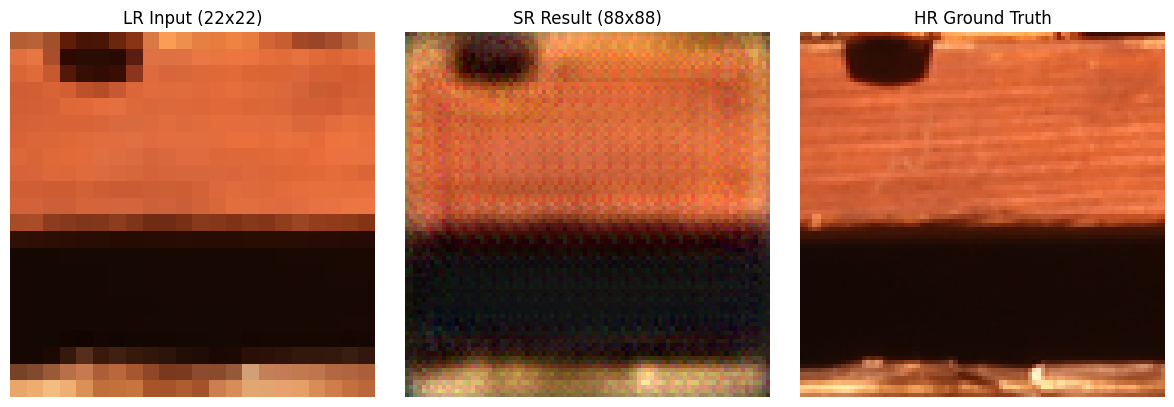


[!] Images saved to /content/drive_new/MyDrive/SR_CNN_Results/images_epoch_30
[!] Checkpoint saved: /content/drive_new/MyDrive/SR_CNN_Results/checkpoint_epoch_30.pth


Epoch [31/60]: 100%|██████████| 13/13 [01:20<00:00,  6.18s/it, loss=0.011674]


 >> Epoch [31/60] Finished. Average Loss: 0.01113541


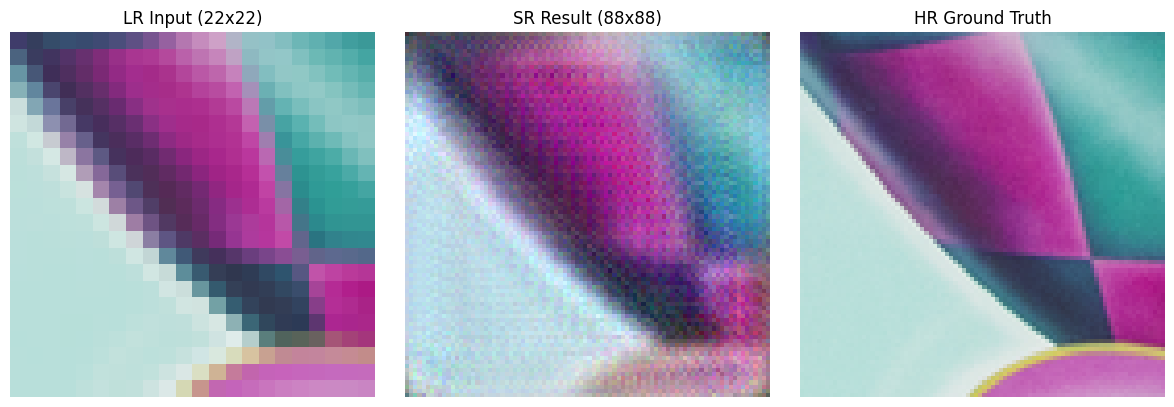

Epoch [32/60]: 100%|██████████| 13/13 [01:19<00:00,  6.15s/it, loss=0.011533]


 >> Epoch [32/60] Finished. Average Loss: 0.01103796


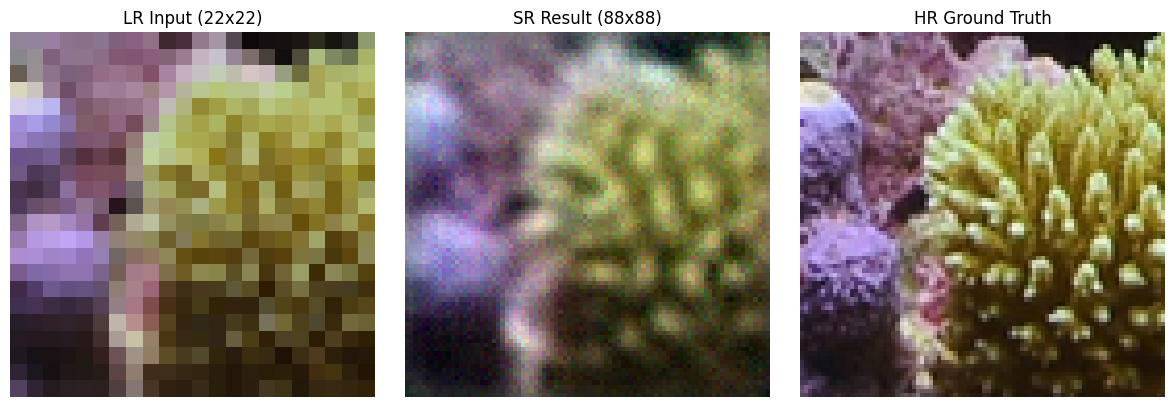

Epoch [33/60]: 100%|██████████| 13/13 [01:19<00:00,  6.15s/it, loss=0.011315]


 >> Epoch [33/60] Finished. Average Loss: 0.01057768


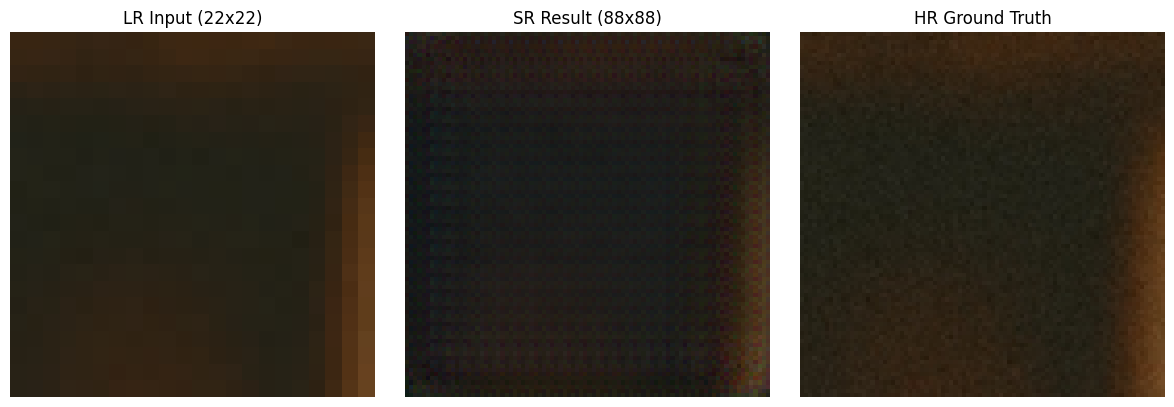

Epoch [34/60]: 100%|██████████| 13/13 [01:19<00:00,  6.14s/it, loss=0.012745]


 >> Epoch [34/60] Finished. Average Loss: 0.01038661


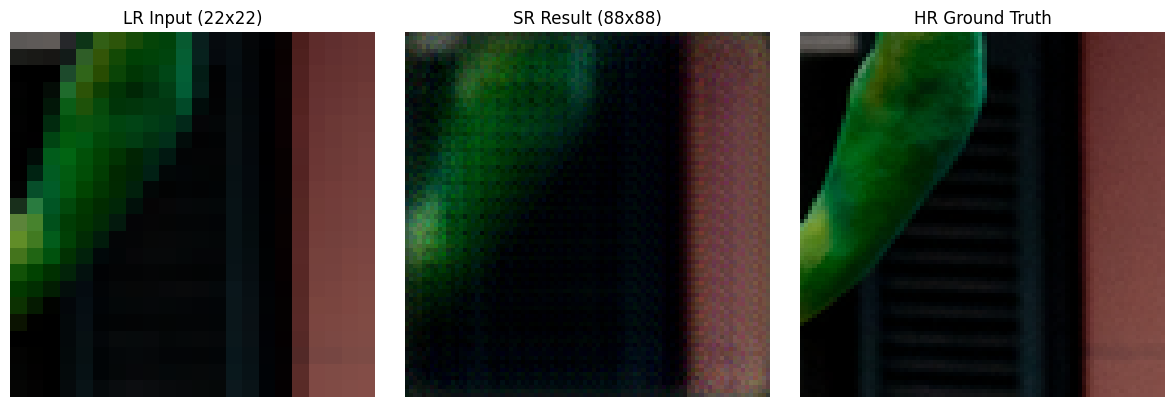

Epoch [35/60]: 100%|██████████| 13/13 [01:20<00:00,  6.19s/it, loss=0.016112]


 >> Epoch [35/60] Finished. Average Loss: 0.01031023


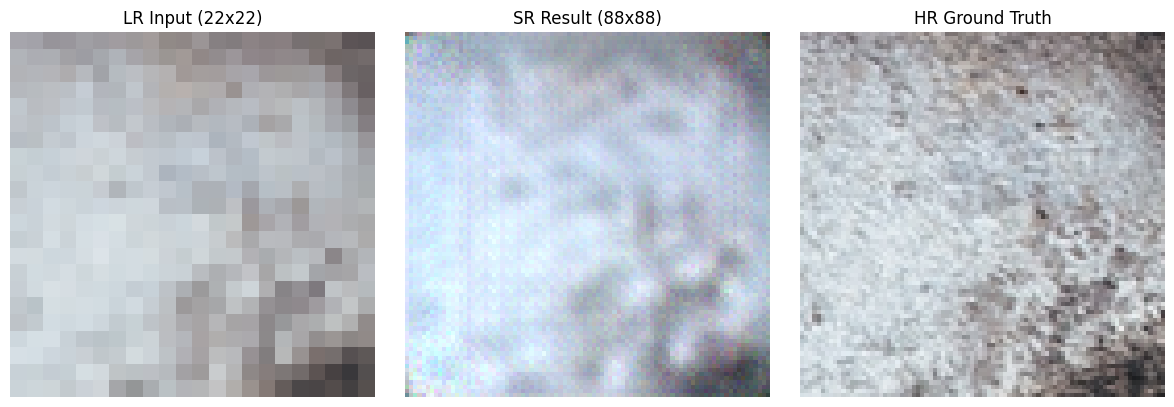


[!] Images saved to /content/drive_new/MyDrive/SR_CNN_Results/images_epoch_35


Epoch [36/60]: 100%|██████████| 13/13 [01:20<00:00,  6.17s/it, loss=0.010990]


 >> Epoch [36/60] Finished. Average Loss: 0.01214824


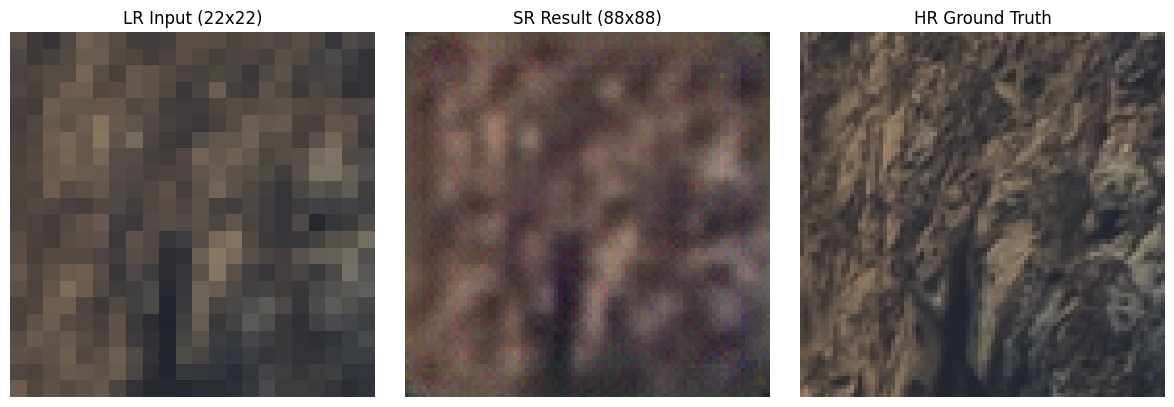

Epoch [37/60]: 100%|██████████| 13/13 [01:20<00:00,  6.20s/it, loss=0.010062]


 >> Epoch [37/60] Finished. Average Loss: 0.01126114


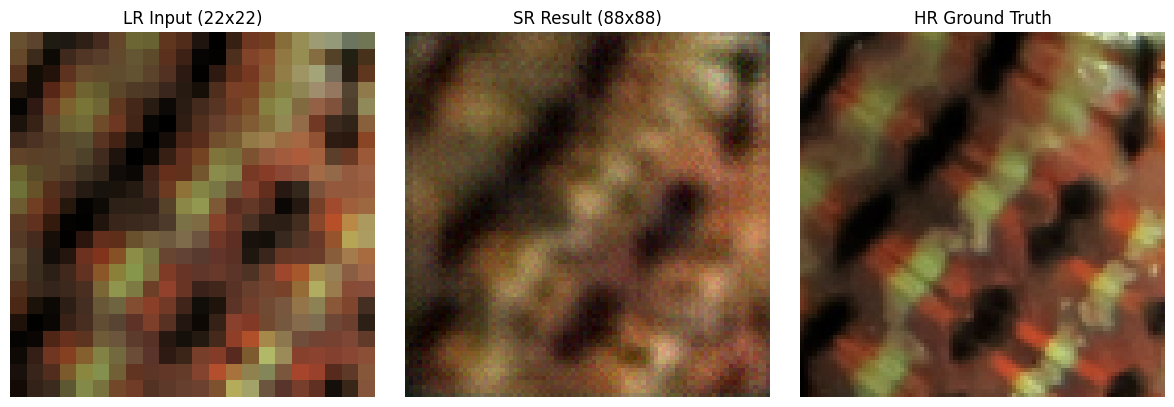

Epoch [38/60]: 100%|██████████| 13/13 [01:21<00:00,  6.24s/it, loss=0.007252]


 >> Epoch [38/60] Finished. Average Loss: 0.01018088


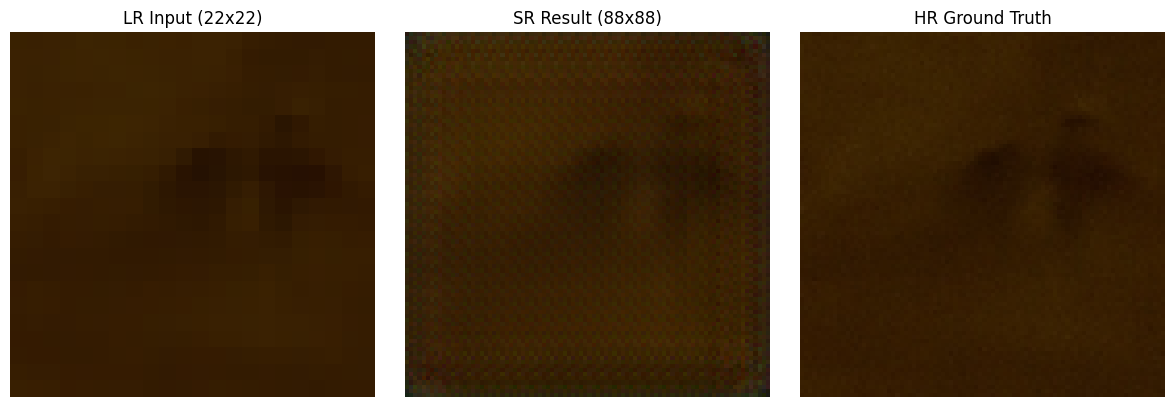

Epoch [39/60]: 100%|██████████| 13/13 [01:22<00:00,  6.31s/it, loss=0.014965]


 >> Epoch [39/60] Finished. Average Loss: 0.01070254


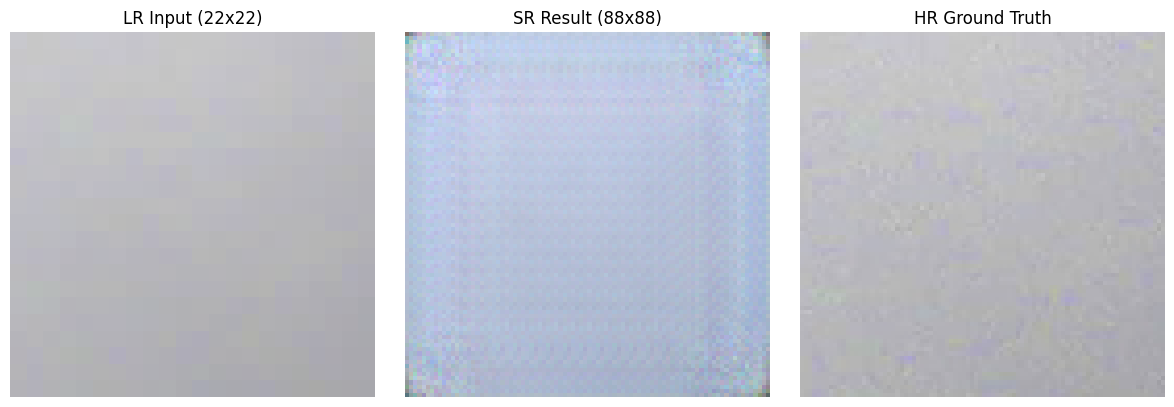

Epoch [40/60]: 100%|██████████| 13/13 [01:20<00:00,  6.19s/it, loss=0.012529]


 >> Epoch [40/60] Finished. Average Loss: 0.01047305


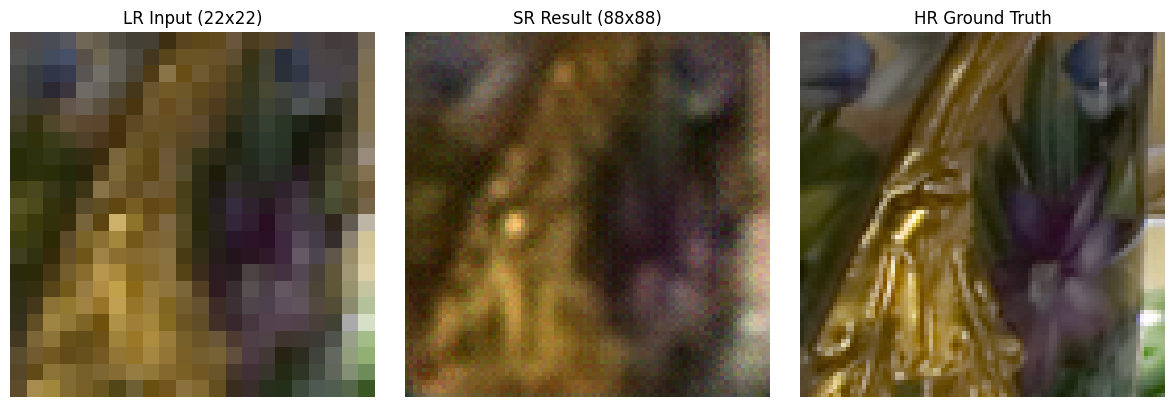


[!] Images saved to /content/drive_new/MyDrive/SR_CNN_Results/images_epoch_40
[!] Checkpoint saved: /content/drive_new/MyDrive/SR_CNN_Results/checkpoint_epoch_40.pth


Epoch [41/60]: 100%|██████████| 13/13 [01:21<00:00,  6.27s/it, loss=0.012107]


 >> Epoch [41/60] Finished. Average Loss: 0.00993550


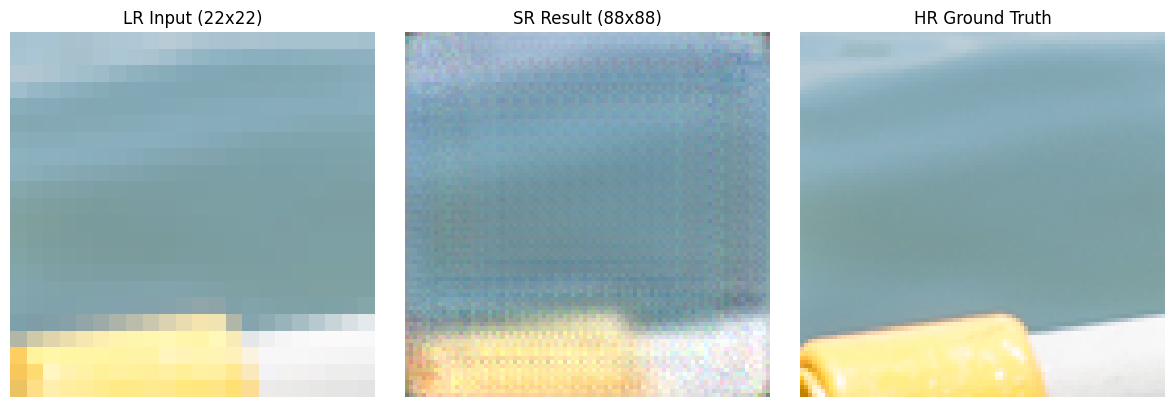

Epoch [42/60]: 100%|██████████| 13/13 [01:21<00:00,  6.24s/it, loss=0.009001]


 >> Epoch [42/60] Finished. Average Loss: 0.00937108


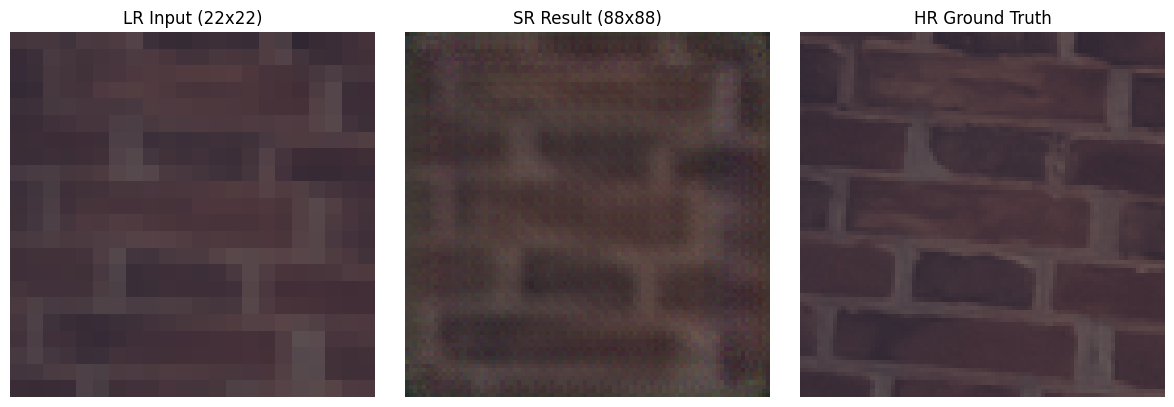

Epoch [43/60]: 100%|██████████| 13/13 [01:21<00:00,  6.28s/it, loss=0.006960]


 >> Epoch [43/60] Finished. Average Loss: 0.01019545


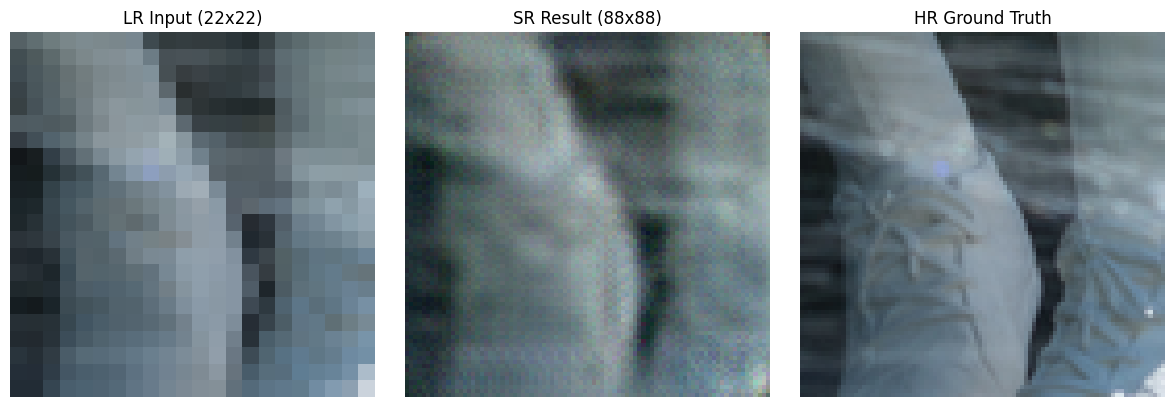

Epoch [44/60]: 100%|██████████| 13/13 [01:20<00:00,  6.22s/it, loss=0.009328]


 >> Epoch [44/60] Finished. Average Loss: 0.01137441


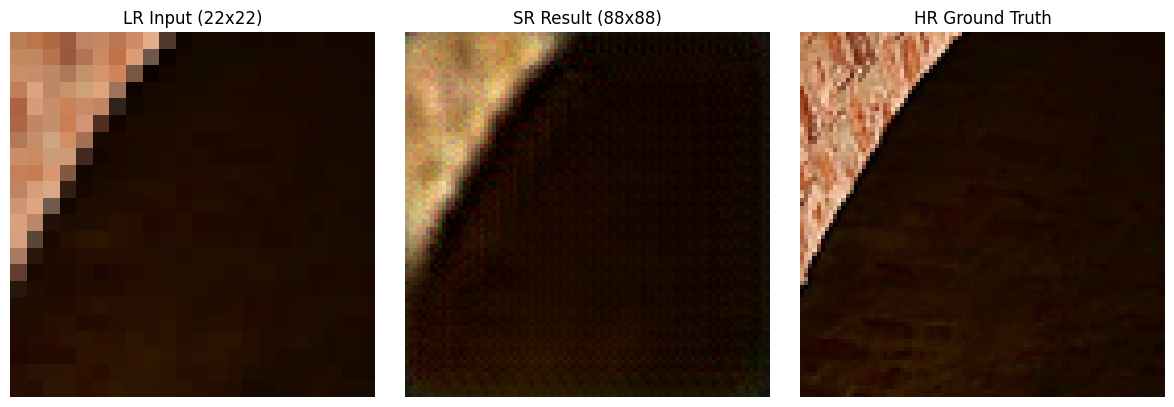

Epoch [45/60]: 100%|██████████| 13/13 [01:21<00:00,  6.29s/it, loss=0.013704]


 >> Epoch [45/60] Finished. Average Loss: 0.01023008


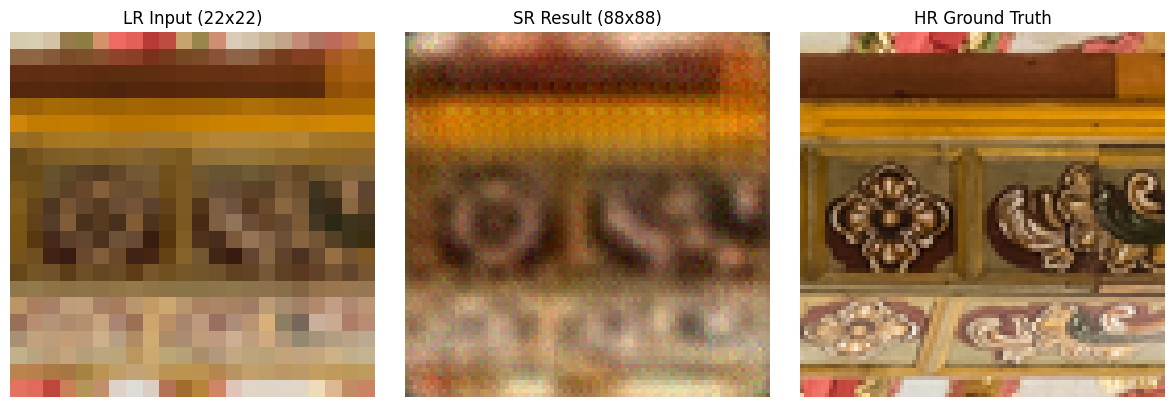


[!] Images saved to /content/drive_new/MyDrive/SR_CNN_Results/images_epoch_45


Epoch [46/60]: 100%|██████████| 13/13 [01:20<00:00,  6.20s/it, loss=0.008330]


 >> Epoch [46/60] Finished. Average Loss: 0.01005277


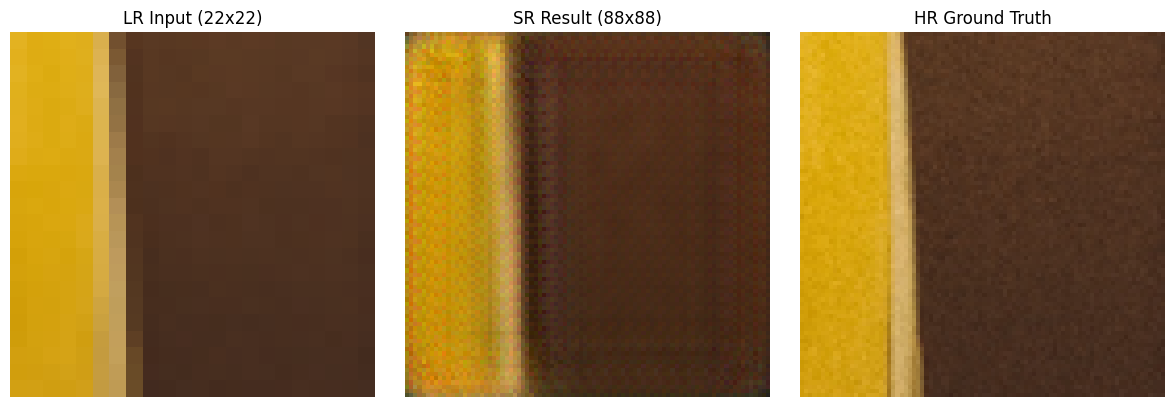

Epoch [47/60]: 100%|██████████| 13/13 [01:20<00:00,  6.19s/it, loss=0.010175]


 >> Epoch [47/60] Finished. Average Loss: 0.01042025


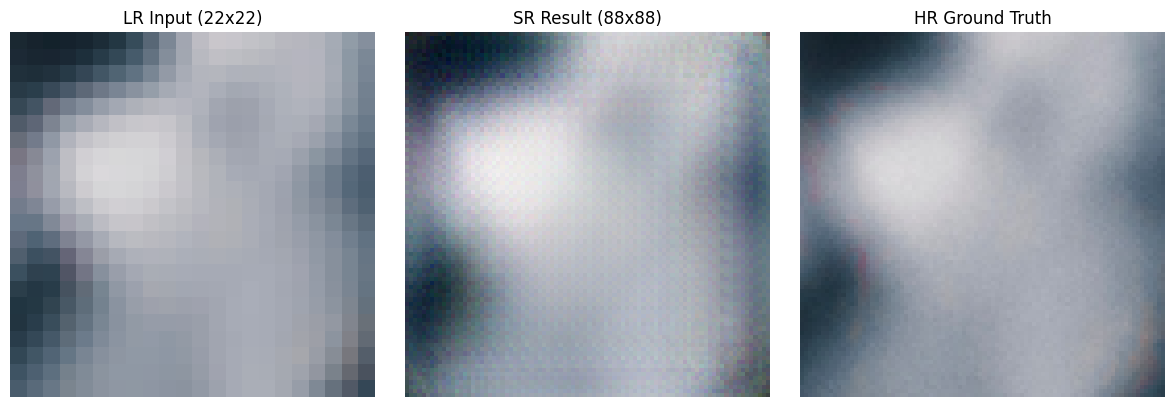

Epoch [48/60]: 100%|██████████| 13/13 [01:20<00:00,  6.17s/it, loss=0.008374]


 >> Epoch [48/60] Finished. Average Loss: 0.01036646


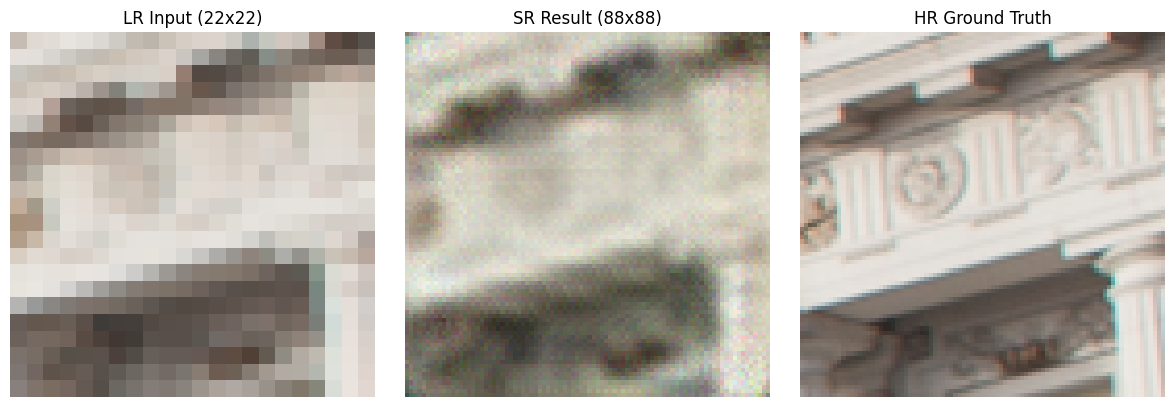

Epoch [49/60]: 100%|██████████| 13/13 [01:20<00:00,  6.17s/it, loss=0.016811]


 >> Epoch [49/60] Finished. Average Loss: 0.01013506


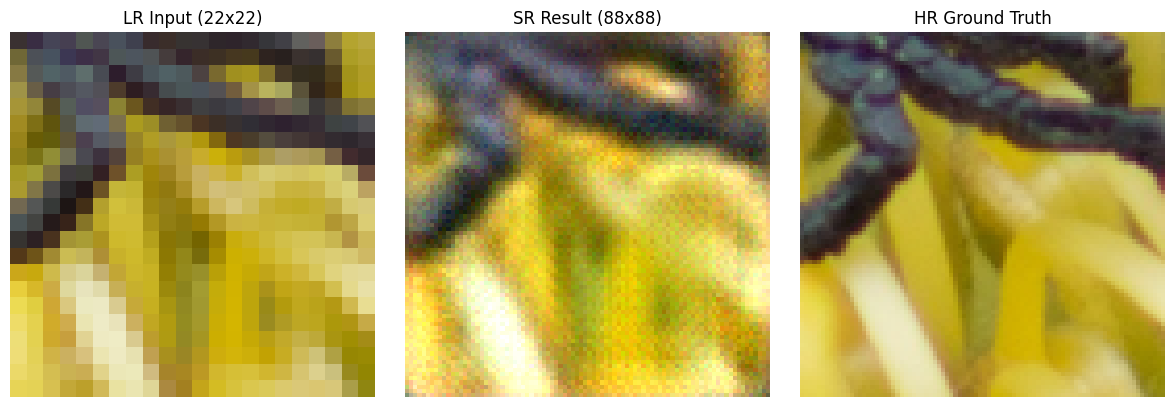

Epoch [50/60]: 100%|██████████| 13/13 [01:21<00:00,  6.27s/it, loss=0.008535]


 >> Epoch [50/60] Finished. Average Loss: 0.00944809


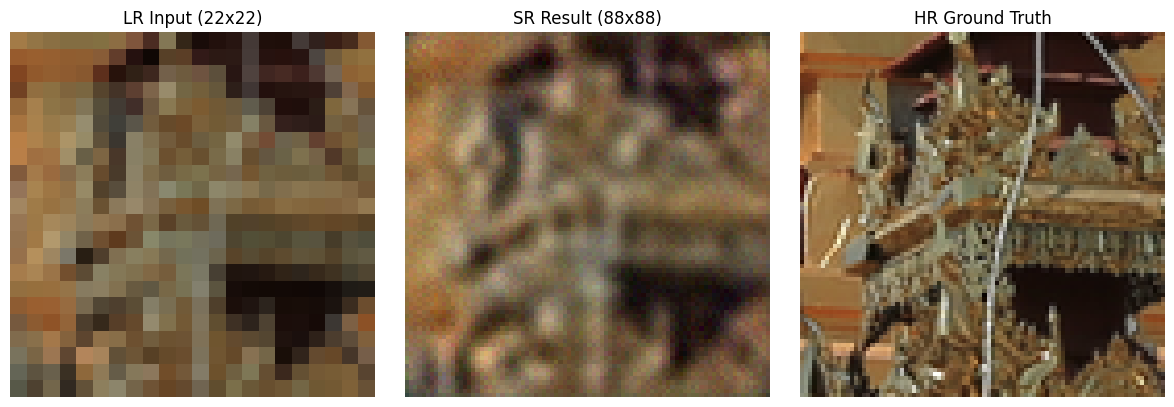


[!] Images saved to /content/drive_new/MyDrive/SR_CNN_Results/images_epoch_50
[!] Checkpoint saved: /content/drive_new/MyDrive/SR_CNN_Results/checkpoint_epoch_50.pth


Epoch [51/60]: 100%|██████████| 13/13 [01:21<00:00,  6.30s/it, loss=0.010618]


 >> Epoch [51/60] Finished. Average Loss: 0.00939111


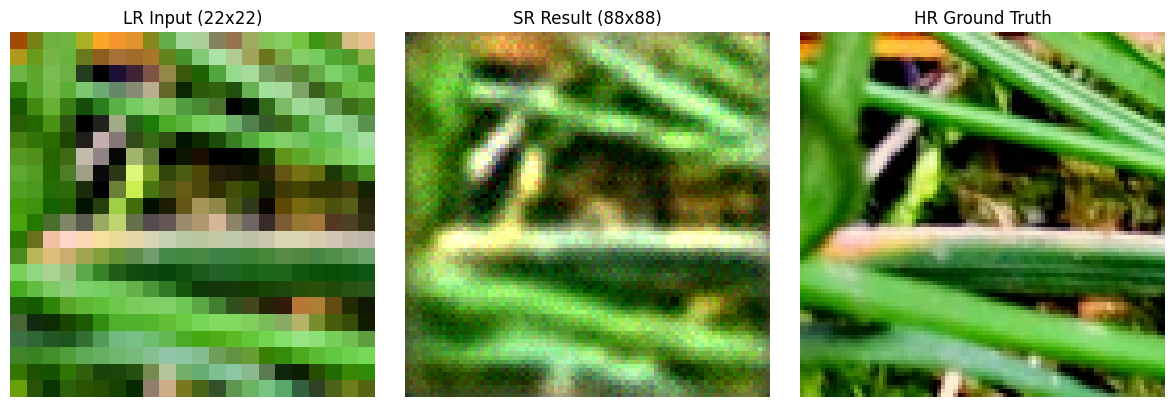

Epoch [52/60]: 100%|██████████| 13/13 [01:21<00:00,  6.24s/it, loss=0.010905]


 >> Epoch [52/60] Finished. Average Loss: 0.00962601


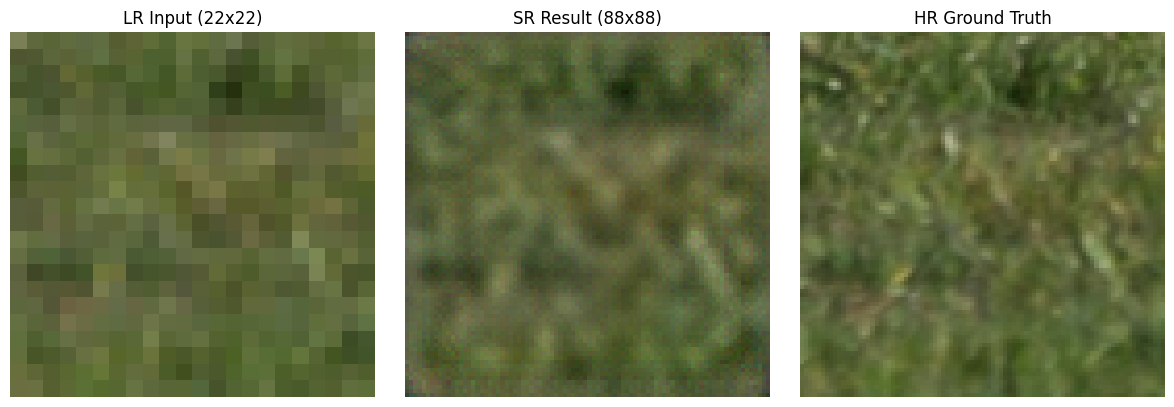

Epoch [53/60]: 100%|██████████| 13/13 [01:21<00:00,  6.29s/it, loss=0.017101]


 >> Epoch [53/60] Finished. Average Loss: 0.00978957


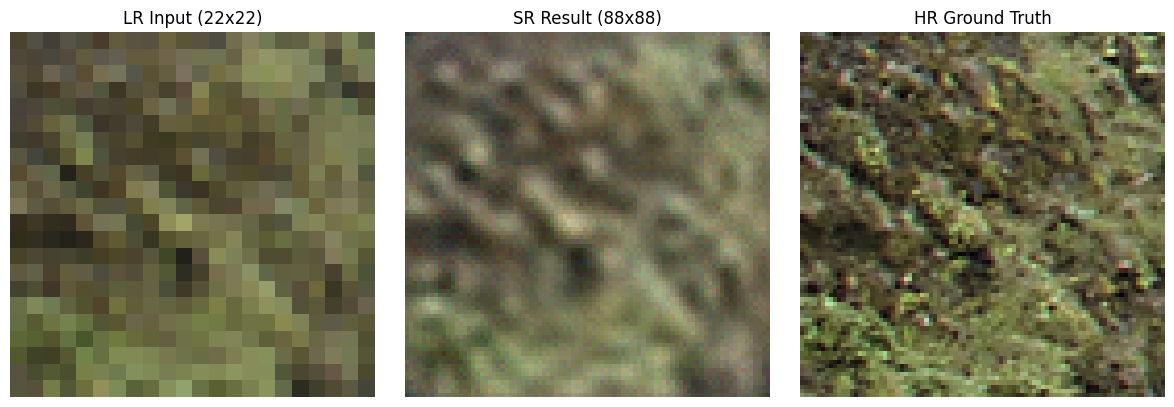

Epoch [54/60]: 100%|██████████| 13/13 [01:22<00:00,  6.33s/it, loss=0.008368]


 >> Epoch [54/60] Finished. Average Loss: 0.00940101


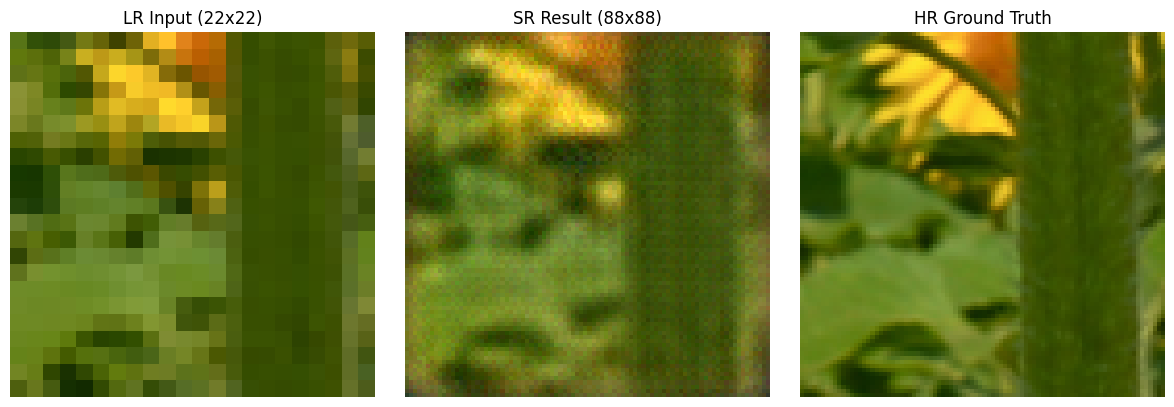

Epoch [55/60]: 100%|██████████| 13/13 [01:21<00:00,  6.26s/it, loss=0.011803]


 >> Epoch [55/60] Finished. Average Loss: 0.01145922


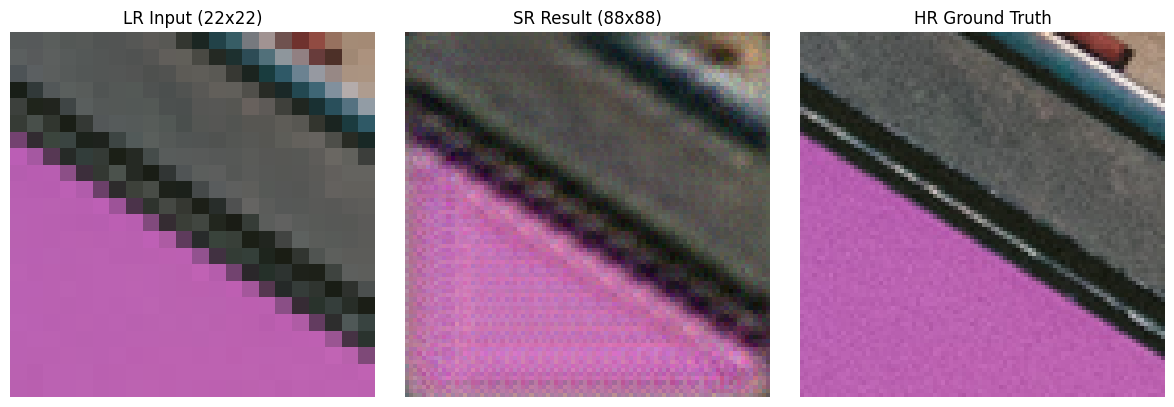


[!] Images saved to /content/drive_new/MyDrive/SR_CNN_Results/images_epoch_55


Epoch [56/60]: 100%|██████████| 13/13 [01:21<00:00,  6.26s/it, loss=0.010644]


 >> Epoch [56/60] Finished. Average Loss: 0.01082089


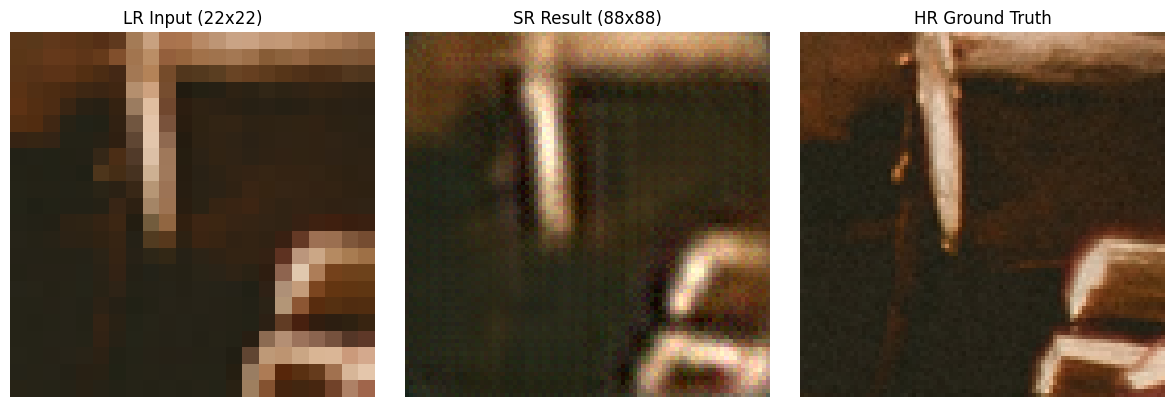

Epoch [57/60]: 100%|██████████| 13/13 [01:21<00:00,  6.27s/it, loss=0.010626]


 >> Epoch [57/60] Finished. Average Loss: 0.01058682


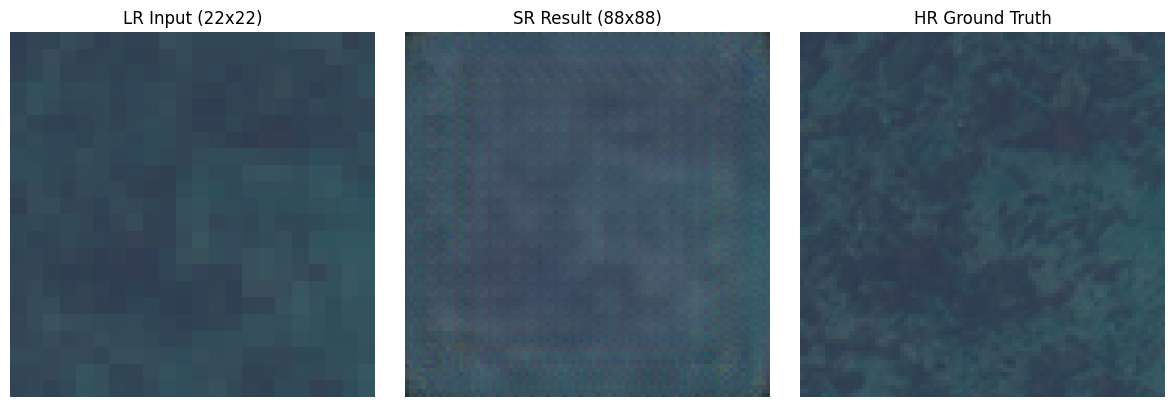

Epoch [58/60]: 100%|██████████| 13/13 [01:21<00:00,  6.28s/it, loss=0.013363]


 >> Epoch [58/60] Finished. Average Loss: 0.01036421


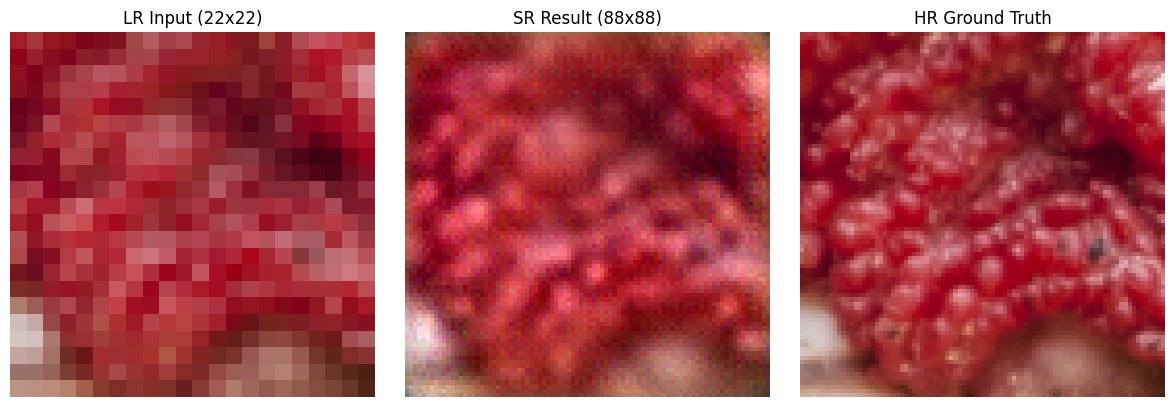

Epoch [59/60]: 100%|██████████| 13/13 [01:21<00:00,  6.24s/it, loss=0.010359]


 >> Epoch [59/60] Finished. Average Loss: 0.00944320


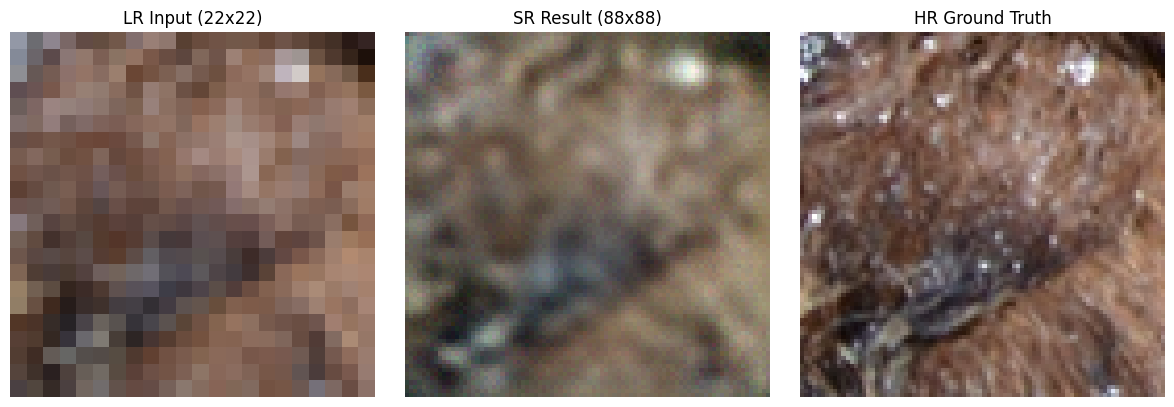

Epoch [60/60]: 100%|██████████| 13/13 [01:21<00:00,  6.25s/it, loss=0.011827]


 >> Epoch [60/60] Finished. Average Loss: 0.00927694


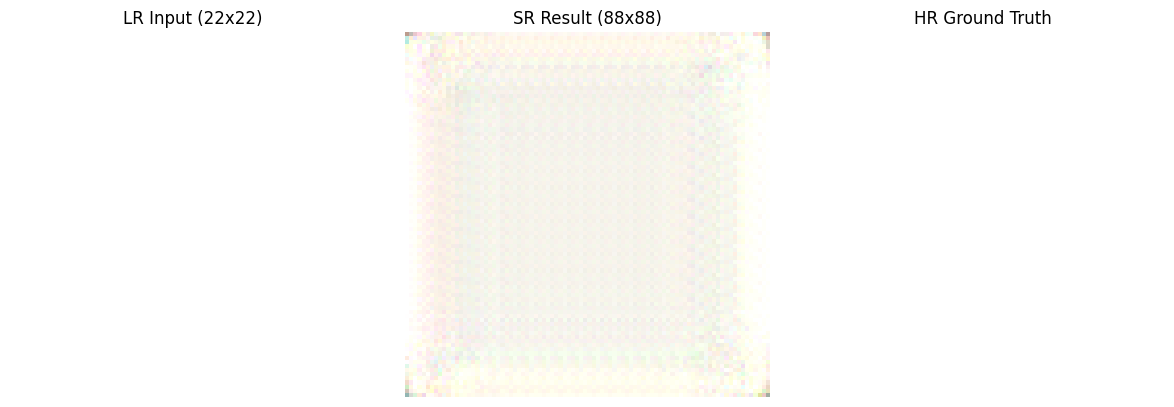


[!] Images saved to /content/drive_new/MyDrive/SR_CNN_Results/images_epoch_60
[!] Checkpoint saved: /content/drive_new/MyDrive/SR_CNN_Results/checkpoint_epoch_60.pth
--- Training Complete ---
Final files saved to /content/drive_new/MyDrive/SR_CNN_Results


ValueError: x and y must have same first dimension, but have shapes (60,) and (120,)

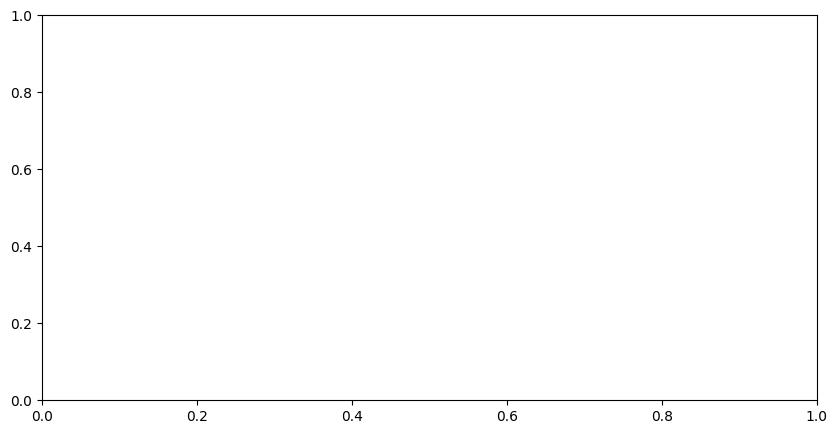

In [ ]:

import os
import torch
import torch.nn as nn
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive_new')

# --- Configuration ---

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LAMBDA_L1 = 0.1
# Change this path to your preferred Drive folder
CNN_SAVE_ROOT = '/content/drive_new/MyDrive/SR_CNN_Results'
os.makedirs(CNN_SAVE_ROOT, exist_ok=True)

# --- Model, Optimizer, and Loss ---
model = SuperResolutionCNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
mse_criterion = nn.MSELoss()
l1_criterion = nn.L1Loss()

epoch_losses = []

# --- Training Loop ---
for epoch in range(1, CNN_EPOCHS + 1):
    model.train()
    running_loss = 0.0
    train_bar = tqdm(train_loader, desc=f"Epoch [{epoch}/{CNN_EPOCHS}]")

    for lr_img, hr_img in train_bar:
        lr_img, hr_img = lr_img.to(DEVICE), hr_img.to(DEVICE)

        optimizer.zero_grad()
        sr_img = model(lr_img)

        loss_mse = mse_criterion(sr_img, hr_img)
        loss_l1 = l1_criterion(sr_img, hr_img)
        total_loss = loss_mse + (LAMBDA_L1 * loss_l1)

        total_loss.backward()
        optimizer.step()

        running_loss += total_loss.item()
        train_bar.set_postfix(loss=f"{total_loss.item():.6f}")

    # 2. PRINT LOSS AFTER EVERY EPOCH
    avg_epoch_loss = running_loss / len(train_loader)
    epoch_losses.append(avg_epoch_loss)
    print(f" >> Epoch [{epoch}/{CNN_EPOCHS}] Finished. Average Loss: {avg_epoch_loss:.8f}")

    # --- NEW: DISPLAY COMPARISON AFTER EVERY EPOCH ---
    model.eval()
    with torch.no_grad():
        # Get one sample from the last batch
        # permute(1, 2, 0) converts (C, H, W) to (H, W, C) for matplotlib
        # clamp(0, 1) ensures valid color range
        view_lr = torch.clamp(lr_img[0], 0, 1).cpu().permute(1, 2, 0)
        view_sr = torch.clamp(sr_img[0], 0, 1).cpu().permute(1, 2, 0)
        view_hr = torch.clamp(hr_img[0], 0, 1).cpu().permute(1, 2, 0)

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(view_lr)
        plt.title(f"LR Input (22x22)")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(view_sr)
        plt.title(f"SR Result (88x88)")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(view_hr)
        plt.title("HR Ground Truth")
        plt.axis("off")

        plt.tight_layout()
        plt.show()
    model.train() # Switch back to training mode

    avg_epoch_loss = running_loss / len(train_loader)
    epoch_losses.append(avg_epoch_loss)

    # --- SAVE IMAGES EVERY 5 EPOCHS ---
    if epoch % 5 == 0:
        model.eval()
        with torch.no_grad():
            # Save a grid or individual images to Drive
            img_path = os.path.join(CNN_SAVE_ROOT, f'images_epoch_{epoch}')
            os.makedirs(img_path, exist_ok=True)

            # Save the first image of the last batch
            save_image(lr_img[0], f'{img_path}/LR_in.png', normalize=True)
            save_image(sr_img[0], f'{img_path}/SR_out.png', normalize=True)
            save_image(hr_img[0], f'{img_path}/HR_target.png', normalize=True)
        print(f"\n[!] Images saved to {img_path}")

    # --- SAVE MODEL EVERY 10 EPOCHS ---
    if epoch % 10 == 0:
        model_path = os.path.join(CNN_SAVE_ROOT, f'checkpoint_epoch_{epoch}.pth')
        torch.save(model.state_dict(), model_path)
        print(f"[!] Checkpoint saved: {model_path}")

# --- FINAL SAVING ---

# 1. Save Final State Dict
final_pth = os.path.join(CNN_SAVE_ROOT, 'cnn_final_weights.pth')
torch.save(model.state_dict(), final_pth)

# 2. Save as .pkl (Saves entire model structure + weights)
final_pkl = os.path.join(CNN_SAVE_ROOT, 'cnn_final_model.pkl')
with open(final_pkl, 'wb') as f:
    pickle.dump(model, f)

print(f"--- Training Complete ---")
print(f"Final files saved to {CNN_SAVE_ROOT}")

# --- PLOT LOSS VS EPOCHS ---
plt.figure(figsize=(10, 5))
plt.plot(range(1, CNN_EPOCHS + 1), epoch_losses, label='Total Loss (MSE + λL1)', color='blue')
plt.title('Training Loss Progression')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(CNN_SAVE_ROOT, 'loss_plot.png')) # Save plot to drive
plt.show()


In [ ]:
!zip -r drive.zip drive

In [ ]:
from google.colab import files
files.download("drive.zip")